In [1]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils

using CairoMakie
using DelimitedFiles
using Distributions
using LinearAlgebra

TODO: Write a utility that resets the named trajectory to random values. Use the current fields like bounds and goal to accomplish this.

TODO: Include the ability of objectives to be multiplied by floats.

In [2]:
# Operators 
const n_levels = 2
at = create(n_levels)
a = annihilate(n_levels)

H_operators = Dict(
        "X" => a + at,
        "Y" => -im * (a - at),
        "Z" => I - 2 * at * a,
)

# Time
T = 50
Δt = 0.2
;

In [3]:
H_drift = zeros(n_levels^4, n_levels^4)
H_controls = [
    kron_from_dict("XIII", H_operators),
    kron_from_dict("IXII", H_operators),
    kron_from_dict("IIXI", H_operators),
    kron_from_dict("IIIX", H_operators),
]

X_gate = GATES[:X]
SX_gate = sqrt(GATES[:X])
U_goal = reduce(kron, [X_gate, X_gate, SX_gate, SX_gate])
;

In [4]:
H_crosstalk = (
    kron_from_dict("ZZII", H_operators)
    + kron_from_dict("IZZI", H_operators)
    + kron_from_dict("IIZZ", H_operators)
    + kron_from_dict("ZIIZ", H_operators)
    + kron_from_dict("ZIII", H_operators)
    + kron_from_dict("IZII", H_operators)
    + kron_from_dict("IIZI", H_operators)
    + kron_from_dict("IIIZ", H_operators)
)

@views function infidelity_robustness(Hₑ::AbstractMatrix, p::QuantumControlProblem)
    Z⃗ = vec(p.trajectory.data)
    Z = p.trajectory
    return InfidelityRobustnessObjective(Hₑ, Z).L(Z⃗, Z)
end

infidelity_robustness (generic function with 1 method)

# Original control problem

In [5]:
prob = UnitarySmoothPulseProblem(
    H_drift,
    H_controls,
    U_goal,
    T,
    Δt;
    a_guess=(π/2/10) * ones((length(H_controls), T)),
    timesteps_all_equal=true,
    free_time=false,
    hessian_approximation=true,
    pade_order=20,
    R=10.,
    R_dda=5.,
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB


applying constraint: initial value of Ũ⃗
applying constraint: 

initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [6]:
solve!(prob; max_iter=75)

println("Fidelity: ", unitary_fidelity(prob))
println("Crosstalk robustness: ", infidelity_robustness(H_crosstalk, prob))



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality c

   1  2.0101726e+01 7.52e-02 6.34e+00 -11.0 7.74e-01    -  1.00e+00 1.00e+00f  1


   2  1.3382965e+01 1.35e-02 3.58e+00 -11.0 4.29e-01    -  1.00e+00 1.00e+00f  1


   3  9.2944041e+00 1.62e-03 1.74e+00 -11.0 1.32e-01    -  1.00e+00 1.00e+00f  1


   4  8.0312939e+00 6.99e-03 5.78e+00 -11.0 2.10e-01    -  1.00e+00 1.00e+00f  1


   5  2.7862006e+00 7.00e-04 3.04e+00 -11.0 6.26e-02    -  1.00e+00 1.00e+00f  1


   6  2.2769526e+00 2.61e-04 5.96e-01 -11.0 4.58e-02    -  1.00e+00 1.00e+00h  1


   7  2.0954282e+00 1.85e-05 6.09e-01 -11.0 5.30e-02    -  1.00e+00 1.00e+00F  1


   8  1.8789955e+00 2.43e-04 6.15e+00 -11.0 1.15e-01    -  1.00e+00 1.00e+00f  1


   9  1.7713601e+00 1.49e-02 2.47e+01 -11.0 8.35e-01    -  1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9172645e+00 1.41e-02 7.66e+00 -11.0 1.17e+00    -  1.00e+00 5.00e-01h  2


  11  1.8686843e+00 1.50e-02 1.19e+01 -11.0 2.58e+01    -  1.00e+00 7.81e-03h  8


  12  1.6920343e+00 1.49e-02 8.32e+00 -11.0 3.54e+00    -  1.00e+00 6.25e-02h  5


  13  1.6166394e+00 1.31e-02 1.02e+01 -11.0 9.77e-01    -  1.00e+00 2.50e-01h  3


  14  1.5248786e+00 1.29e-02 6.45e+00 -11.0 2.13e+00    -  1.00e+00 1.25e-01h  4


  15  1.2832315e+00 1.14e-02 8.19e+00 -11.0 7.23e-01    -  1.00e+00 2.50e-01h  3


  16  1.2090459e+00 1.21e-02 4.09e+00 -11.0 1.97e+00    -  1.00e+00 1.25e-01h  4


  17  1.1630837e+00 1.24e-02 5.46e+00 -11.0 7.39e+00    -  1.00e+00 3.12e-02h  6


  18  1.1883212e+00 1.24e-02 7.04e+00 -11.0 4.36e+01    -  1.00e+00 4.88e-04h 12


  19  1.6271248e+00 4.61e-03 3.73e+00 -11.0 4.10e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0866280e+00 2.35e-03 3.73e+00 -11.0 4.72e-01    -  1.00e+00 1.00e+00h  1


  21  1.3091021e+00 1.51e-03 2.90e+00 -11.0 1.88e-01    -  1.00e+00 1.00e+00h  1


  22  1.1130358e+00 1.39e-03 2.84e+00 -11.0 1.98e-01    -  1.00e+00 1.00e+00h  1


  23  1.2024212e+00 4.95e-04 3.41e+00 -11.0 4.16e-01    -  1.00e+00 2.50e-01h  3


  24  1.1054705e+00 6.70e-04 2.12e+00 -11.0 1.78e-01    -  1.00e+00 1.00e+00h  1


  25  1.0945650e+00 1.46e-03 1.62e+00 -11.0 4.62e-01    -  1.00e+00 1.00e+00H  1


  26  1.1332328e+00 5.28e-05 1.47e+00 -11.0 3.84e-01    -  1.00e+00 1.00e+00H  1


  27  1.0243350e+00 1.74e-04 6.49e+00 -11.0 3.21e-01    -  1.00e+00 1.00e+00f  1


  28  1.0232322e+00 1.71e-04 6.63e-01 -11.0 6.10e-01    -  1.00e+00 1.56e-02h  7


  29  9.8360057e-01 1.15e-04 1.85e+00 -11.0 8.89e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.6301096e-01 1.92e-04 2.98e+00 -11.0 7.93e-02    -  1.00e+00 1.00e+00h  1


  31  9.4731888e-01 9.72e-04 2.17e+00 -11.0 9.54e-01    -  1.00e+00 1.25e-01h  4


  32  9.1527367e-01 1.67e-03 2.37e+00 -11.0 3.48e-01    -  1.00e+00 5.00e-01h  2


  33  8.7888719e-01 3.10e-03 2.72e+00 -11.0 6.44e-01    -  1.00e+00 2.50e-01h  3


  34  8.4845631e-01 3.33e-03 2.73e+00 -11.0 1.67e+01    -  1.00e+00 7.81e-03h  8


  35  8.3666985e-01 3.62e-03 2.73e+00 -11.0 1.13e+01    -  1.00e+00 7.81e-03h  8


  36  8.2680240e-01 4.44e-03 2.76e+00 -11.0 1.01e+00    -  1.00e+00 1.25e-01h  4


  37  8.1655903e-01 5.08e-03 2.77e+00 -11.0 3.82e+00    -  1.00e+00 3.12e-02h  6


  38  8.1286621e-01 5.04e-03 3.47e+00 -11.0 1.77e+00    -  1.00e+00 1.56e-02h  7


  39  8.0109512e-01 4.54e-03 3.40e+00 -11.0 3.75e-01    -  1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  8.2092635e-01 4.40e-03 3.39e+00 -11.0 3.93e+00    -  1.00e+00 3.12e-02h  6


  41  1.0803141e+00 7.96e-03 3.13e+00 -11.0 3.58e-01    -  1.00e+00 1.00e+00w  1


  42  7.2168990e-01 8.86e-03 3.13e+00 -11.0 2.66e-01    -  1.00e+00 1.00e+00h  1


  43  7.0601332e-01 4.73e-03 3.10e+00 -11.0 2.72e-01    -  1.00e+00 5.00e-01h  2


  44  8.1157404e-01 3.32e-03 3.17e+00 -11.0 3.51e-01    -  1.00e+00 5.00e-01h  2


  45  7.9481359e-01 2.77e-03 3.18e+00 -11.0 3.61e-01    -  1.00e+00 2.50e-01h  3


  46  7.2870461e-01 3.08e-03 3.05e+00 -11.0 1.36e+00    -  1.00e+00 6.25e-02h  5


  47  8.1004635e-01 2.79e-04 3.30e+00 -11.0 9.12e-02    -  1.00e+00 1.00e+00h  1


  48  7.9283973e-01 6.61e-04 3.35e+00 -11.0 1.84e-01    -  1.00e+00 5.00e-01h  2


  49  7.9072760e-01 2.96e-04 3.42e+00 -11.0 4.91e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  8.9002233e-01 7.03e-05 2.94e+00 -11.0 1.02e-01    -  1.00e+00 1.00e+00h  1


  51  8.3862656e-01 9.54e-05 2.50e+00 -11.0 1.02e-01    -  1.00e+00 1.00e+00H  1


  52  8.3731868e-01 1.21e-04 2.36e+00 -11.0 2.28e-01    -  1.00e+00 2.50e-01h  3


  53  8.4017794e-01 5.37e-05 4.06e+00 -11.0 6.11e-02    -  1.00e+00 1.00e+00h  1


  54  8.3939495e-01 1.00e-04 3.95e+00 -11.0 5.62e-01    -  1.00e+00 6.25e-02h  5


  55  8.3534657e-01 7.67e-05 2.01e+00 -11.0 1.58e-01    -  1.00e+00 2.50e-01h  3


  56  8.1986192e-01 7.05e-05 1.96e+00 -11.0 7.90e-02    -  1.00e+00 1.00e+00h  1


  57  8.1701270e-01 1.96e-05 4.43e+00 -11.0 2.36e-02    -  1.00e+00 1.00e+00h  1


  58  8.2075862e-01 4.60e-06 1.74e+00 -11.0 2.22e-02    -  1.00e+00 1.00e+00h  1


  59  8.1982206e-01 3.10e-06 1.38e+00 -11.0 1.80e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  8.1958476e-01 1.05e-06 1.09e+00 -11.0 4.66e-03    -  1.00e+00 1.00e+00h  1


  61  8.1925515e-01 8.59e-07 5.57e-01 -11.0 4.74e-03    -  1.00e+00 1.00e+00h  1


  62  8.1934280e-01 1.38e-08 2.65e-01 -11.0 5.42e-03    -  1.00e+00 1.00e+00H  1


  63  8.1900943e-01 4.63e-06 2.94e-01 -11.0 1.18e-01    -  1.00e+00 6.25e-02h  5


  64  8.1845827e-01 1.24e-05 3.26e-01 -11.0 3.82e-02    -  1.00e+00 2.50e-01h  3


  65  8.1785805e-01 1.58e-05 3.97e-01 -11.0 3.95e-02    -  1.00e+00 5.00e-01h  2


  66  8.1758172e-01 1.77e-05 4.88e-01 -11.0 6.34e-02    -  1.00e+00 2.50e-01h  3


  67  8.1673740e-01 7.18e-05 7.38e-01 -11.0 4.95e-02    -  1.00e+00 5.00e-01h  2


  68  8.1521193e-01 5.00e-05 6.27e+00 -11.0 2.38e-02    -  1.00e+00 5.00e-01h  2


  69  8.1498614e-01 1.15e-04 1.78e+00 -11.0 9.53e-02    -  1.00e+00 5.00e-01h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  8.1658822e-01 2.52e-05 1.97e+00 -11.0 5.52e-02    -  1.00e+00 1.00e+00h  1


  71  8.1692635e-01 8.09e-06 1.13e+00 -11.0 2.50e-02    -  1.00e+00 1.00e+00h  1


  72  8.1544179e-01 6.74e-06 8.55e-01 -11.0 4.17e-02    -  1.00e+00 5.00e-01h  2


  73  8.1511297e-01 5.76e-06 6.02e-01 -11.0 2.13e-02    -  1.00e+00 1.00e+00h  1


  74  8.1599902e-01 6.06e-06 7.23e-01 -11.0 1.60e-02    -  1.00e+00 1.00e+00h  1


  75  8.1806532e-01 8.43e-08 8.73e-02 -11.0 1.82e-02    -  1.00e+00 1.00e+00H  1



Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   8.1806531539475213e-01    8.1806531539475213e-01
Dual infeasibility......:   8.7343102170518105e-02    8.7343102170518105e-02
Constraint violation....:   8.4334938588170871e-08    8.4334938588170871e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   8.7343102170518105e-02    8.7343102170518105e-02


Number of objective function evaluations             = 253
Number of objective gradient evaluations             = 76
Number of equality constraint evaluations            = 260
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 76
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT       

0.03074784775017633


In [7]:
function plot_control(
    ts::AbstractVector, 
    as::Union{Nothing, AbstractMatrix}=nothing,
    das::Union{Nothing, AbstractMatrix}=nothing,
    ddas::Union{Nothing, AbstractMatrix}=nothing,
)
    # plot(prob.trajectory; comps=[:a, :da, :dda])
    f = Figure(resolution=(800, 600))
    colors = [:red, :green, :blue, :orange, :purple, :yellow, :black]

    if !isnothing(as)
        ax1 = Axis(f[1, 1])
        for i in 1:size(as, 1)
            lines!(ax1, ts, as[i, :]; color=colors[i])
        end
    end
    if !isnothing(das)
        ax2 = Axis(f[2, 1])
        for i in 1:size(as, 1)
            lines!(ax2, ts, das[i, :]; color=colors[i])
        end
    end
    if !isnothing(ddas)
        ax3 = Axis(f[3, 1])
        for i in 1:size(as, 1)
            lines!(ax3, ts, ddas[i, :]; color=colors[i])
        end
    end
    return f
end

function plot_control(prob::QuantumControlProblem)
    ts = accumulate(+, timesteps(prob.trajectory))
    as = prob.trajectory[:a]
    das = prob.trajectory[:da]
    ddas = prob.trajectory[:dda]
    return plot_control(ts, as, das, ddas)
    f = Figure(resolution=(800, 600))
end



plot_control (generic function with 5 methods)

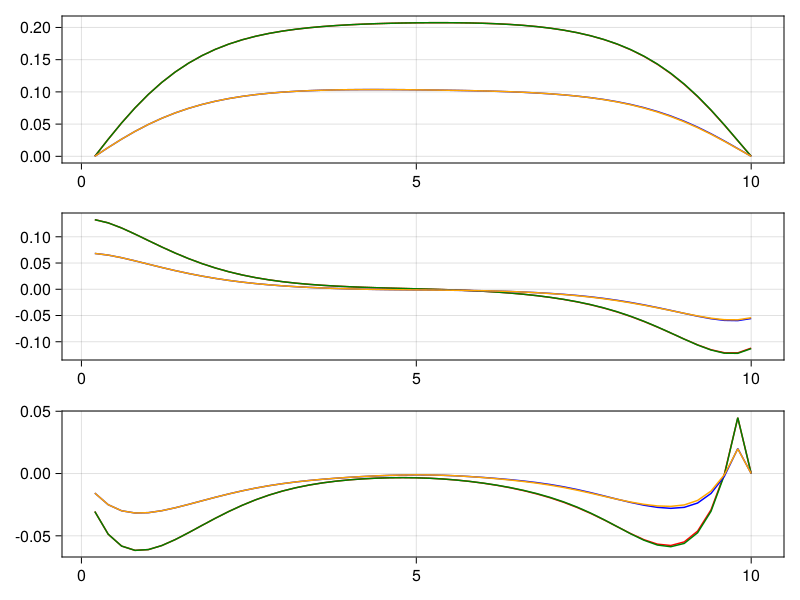

In [8]:
plot_control(prob)

In [41]:
println("max(a): ", maximum(prob.trajectory[:a]))
println("max(dda): ", maximum(prob.trajectory[:dda]))

max(a): 0.2074009427887957


In [38]:
save("saved-pulses/single_qubit_gateset_default.jld2", prob.trajectory)

In [57]:
writedlm("saved-pulses/a_single_qubit_gateset_default.csv", prob.trajectory[:a], ",")

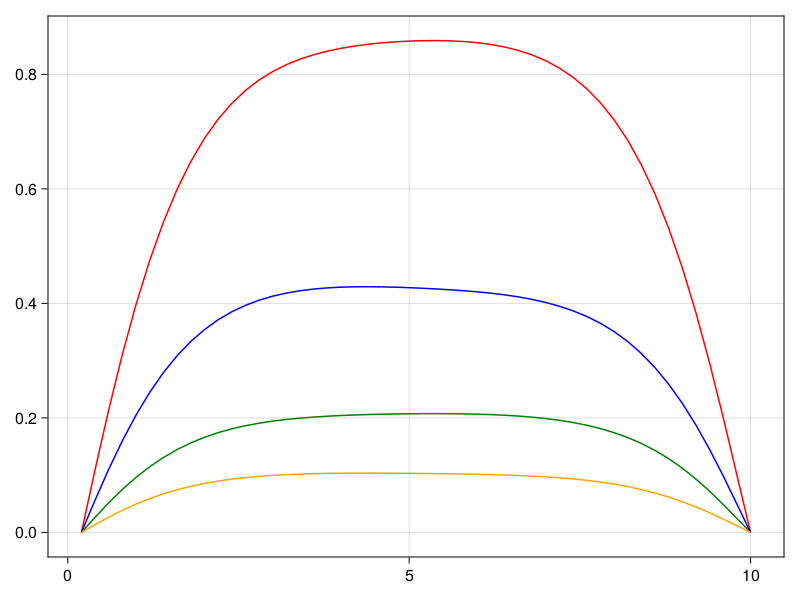

In [9]:
plot_control(accumulate(+, timesteps(prob.trajectory)), [1 + π, 1, 1 + π, 1] .* prob.trajectory[:a])


In [10]:
function random_a_guess(traj::NamedTrajectory)
    # Positive (symmetric) upper bounds
    a_bounds = traj.bounds[:a][2]

    a_dists = [Uniform(
        -(a_bounds[i] == Inf ? 1.0 : a_bounds[i]),
        (a_bounds[i] == Inf ? 1.0 : a_bounds[i])
    ) for i = 1:traj.dims[:a]]

    a = hcat([
        zeros(traj.dims[:a]),
        vcat([rand(a_dists[i], 1, T - 2) for i = 1:traj.dims[:a]]...),
        zeros(traj.dims[:a])
    ]...)
    return a
end

random_a_guess (generic function with 1 method)

# Offset initial controls with amplitude contraint

In [11]:
trajectory = copy(prob.trajectory)
# Need random initial conditions to avoid local minima
# update!(trajectory, :a, random_a_guess(trajectory))
update!(trajectory, :a, [1 + π, 1, 1 + π, 1] .* prob.trajectory[:a])
update!(trajectory, :Ũ⃗, 2 * rand(trajectory.dims[:Ũ⃗], T) .- 1)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += Objective(parameters[:objective_terms][1])
objective += QuadraticRegularizer(:dda, trajectory, 1e-3)
objective += QuadraticRegularizer(:a, trajectory, 1e-6)

update_bound!(trajectory, :a, 1.0)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_1 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9, 
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [12]:
solve!(rob_prob_1; max_iter=50)

println("Fidelity: ", unitary_fidelity(rob_prob_1))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_1))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      192
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.1897094e+01 2.08e+00 2.62e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  8.2166087e+01 2.06e+00 1.08e+02  -1.0 1.93e+00    -  9.93e-01 9.85e-03h  1


   2  1.0301517e+01 4.20e-01 9.78e+01  -1.2 1.82e+01    -  5.27e-01 1.00e+00h  1


   3  3.0145442e+00 1.39e-01 9.77e+01  -4.0 3.29e+00    -  1.10e-02 1.00e+00h  1


   4  9.5735564e+00 1.40e-01 9.79e+01  -0.0 9.33e+01    -  7.79e-02 4.28e-03h  4


   5  4.7006398e+00 3.01e-01 3.62e+01  -0.6 1.62e+01    -  1.00e+00 1.00e+00f  1


   6  8.3350779e+00 2.31e-01 2.25e+01  -0.7 1.33e+01    -  7.98e-01 2.95e-01h  1


   7  8.7258008e+00 2.32e-01 1.75e+01  -0.7 1.56e+01    -  4.59e-01 3.72e-01H  1


   8  7.8650966e+00 2.74e-01 7.98e+01  -1.0 1.50e+01    -  3.84e-01 1.00e+00h  1


   9  5.0665067e+00 3.66e-01 7.57e+01  -4.0 1.55e+01    -  5.09e-02 5.42e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7815349e+00 1.13e-01 2.83e+00  -1.5 6.52e+00    -  7.59e-01 1.00e+00h  1


  11  8.9444739e-01 7.41e-02 2.88e+00  -3.2 5.49e+00    -  6.01e-01 6.39e-01h  1


  12  2.5719160e+00 1.05e-01 3.36e+00  -1.4 5.82e+00    -  1.00e+00 4.19e-01h  1


  13  7.5785812e-01 5.49e-02 3.52e+00  -1.5 1.38e+00    -  9.67e-01 1.00e+00h  1


  14  2.0784313e+00 1.24e-02 2.89e+00  -1.9 7.11e-01    -  9.94e-01 9.04e-01h  1


  15  9.3713231e-01 6.49e-03 3.01e+00  -1.7 4.26e-01    -  8.23e-01 1.00e+00h  1


  16  3.3359267e-01 5.78e-03 3.24e+00  -1.5 6.99e+00    -  3.26e-01 1.10e-01f  4


  17  3.1591327e-01 6.34e-04 2.94e+00  -2.5 3.88e-01    -  9.99e-01 1.00e+00h  1


  18  4.2536242e-02 5.61e-04 2.93e+00  -3.5 1.69e-01    -  1.00e+00 1.00e+00h  1


  19  3.4417912e-02 5.59e-04 3.33e+00  -3.6 3.39e+00    -  1.00e+00 7.14e-03h  7


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.0976159e-02 4.46e-04 3.50e+00  -4.0 4.44e-02    -  1.00e+00 2.17e-01h  1


  21  5.1044023e-02 5.03e-05 3.05e+00  -4.0 7.79e-02    -  1.00e+00 1.00e+00h  1


  22  3.5181671e-02 7.16e-04 3.03e+00  -3.6 6.24e-01    -  4.82e-01 1.00e+00h  1


  23  3.4144723e-02 8.82e-04 3.22e+00  -3.9 1.05e+01    -  9.36e-02 3.44e-02h  5


  24  2.2646822e-02 3.39e-04 3.14e+00  -3.9 2.01e-01    -  1.00e+00 1.00e+00h  1


  25  2.7699245e-02 2.20e-04 3.12e+00  -4.0 1.60e-01    -  1.00e+00 1.00e+00h  1


  26  2.3005108e-02 8.66e-04 3.13e+00  -4.0 1.61e-01    -  1.00e+00 1.00e+00h  1


  27  2.2027063e-02 8.49e-04 3.12e+00  -4.1 3.37e+01    -  6.46e-02 3.13e-03h  6


  28  2.3258480e-02 1.91e-02 3.12e+00  -3.7 3.26e+00    -  1.00e+00 1.00e+00h  1


  29  1.9463542e-02 2.12e-03 3.12e+00  -3.7 1.43e+00    -  7.33e-01 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6455021e-02 1.01e-02 3.12e+00  -4.0 1.06e+00    -  1.00e+00 1.00e+00h  1


  31  2.5135788e-02 1.01e-01 3.12e+00  -2.0 3.68e+01    -  4.93e-01 8.92e-02h  2


  32  2.0271502e-02 2.97e-02 3.13e+00  -2.4 7.04e-01    -  1.00e+00 1.00e+00h  1


  33  1.6302707e-02 3.74e-02 3.13e+00  -2.4 1.64e+00    -  1.00e+00 1.00e+00h  1


  34  1.1110828e-02 2.14e-03 3.13e+00  -3.7 5.56e-01    -  1.00e+00 1.00e+00h  1


  35  1.1169266e-02 2.05e-03 3.12e+00  -4.0 1.74e+00    -  1.00e+00 2.50e-01h  3


  36  8.3920778e-03 7.31e-03 3.12e+00  -4.0 1.46e+00    -  1.00e+00 1.00e+00h  1


  37  7.8952009e-03 1.21e-02 3.13e+00  -4.0 5.30e-01    -  1.00e+00 1.00e+00h  1


  38  6.9086328e-03 6.30e-03 3.13e+00  -4.0 4.00e-01    -  1.00e+00 1.00e+00h  1


  39  7.9787304e-03 3.03e-03 3.12e+00  -4.0 4.10e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.9642293e-03 1.08e-03 3.12e+00  -4.0 2.21e-01    -  1.00e+00 1.00e+00h  1


  41  6.3115877e-03 1.33e-03 3.13e+00  -4.0 5.70e-01    -  1.00e+00 5.00e-01h  2


  42  5.9045651e-03 5.11e-04 3.12e+00  -4.0 2.01e-01    -  1.00e+00 1.00e+00h  1


  43  5.8620074e-03 2.54e-04 3.13e+00  -4.0 1.19e-01    -  1.00e+00 1.00e+00h  1


  44  5.6943379e-03 2.57e-04 3.13e+00  -4.0 1.30e-01    -  1.00e+00 1.00e+00h  1


  45  5.4796441e-03 2.59e-03 3.12e+00  -4.0 1.70e+00    -  1.00e+00 2.50e-01h  3


  46  4.6666589e-03 7.76e-04 3.12e+00  -4.0 1.03e-01    -  1.00e+00 1.00e+00h  1


  47  4.1842315e-03 7.86e-04 3.13e+00  -4.0 5.17e-01    -  1.00e+00 5.00e-01h  2


  48  3.9632675e-03 4.54e-04 3.12e+00  -4.0 1.65e-01    -  1.00e+00 1.00e+00h  1


  49  3.9520217e-03 2.37e-04 3.13e+00  -4.0 8.53e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.8064972e-03 2.16e-04 3.13e+00  -4.0 8.87e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   3.8064972378635390e-03    3.8064972378635390e-03
Dual infeasibility......:   3.1260754520573828e+00    3.1260754520573828e+00
Constraint violation....:   2.1644180912905320e-04    2.1644180912905320e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.9999999992245154e-05    9.9999999992245154e-05
Overall NLP error.......:   3.1260754520573828e+00    3.1260754520573828e+00


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 95
Number of inequality constraint evaluations          = 95
Number of equality constraint Jacobian e

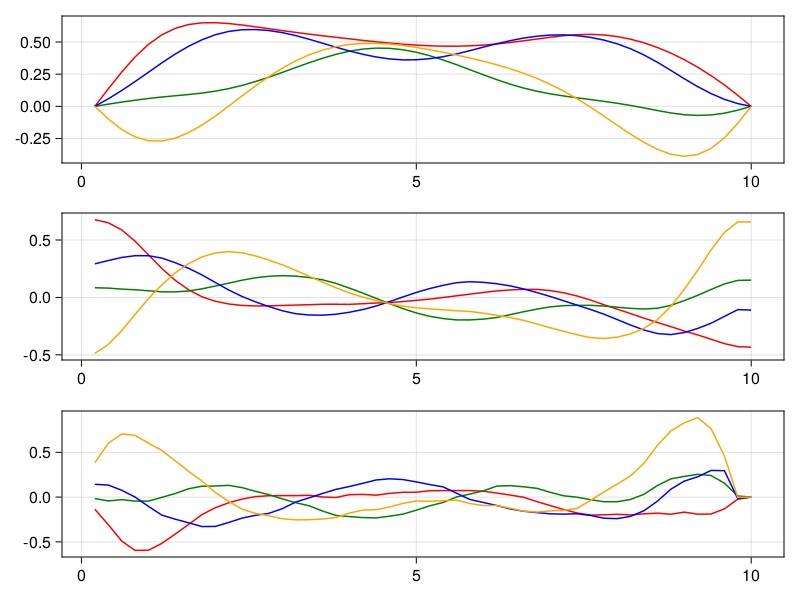

In [13]:
plot_control(rob_prob_1)

In [14]:
trajectory = copy(rob_prob_1.trajectory)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += QuadraticRegularizer(:dda, trajectory, 1e-5)
objective += QuadraticRegularizer(:a, trajectory, 1e-5)

update_bound!(trajectory, :a, Inf)
update_bound!(trajectory, :dda, Inf)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_2 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9999,
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [15]:
solve!(rob_prob_2; max_iter=200)

println("Fidelity: ", unitary_fidelity(rob_prob_2))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_2))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5202746e-03 2.16e-04 6.86e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  3.5157277e-03 1.33e-03 2.40e-02  -4.0 1.16e-02    -  1.00e+00 8.56e-01h  1


   2  3.4889771e-03 5.26e-05 2.49e-03  -4.0 3.40e-02    -  1.00e+00 1.00e+00h  1


   3  3.4488701e-03 1.56e-05 1.23e-03  -4.0 1.53e-02    -  1.00e+00 1.00e+00h  1


   4  3.4062323e-03 1.57e-05 5.66e-04  -4.0 1.71e-02    -  1.00e+00 1.00e+00h  1


   5  3.4014022e-03 2.06e-06 3.03e-04  -4.0 5.35e-03    -  1.00e+00 1.00e+00h  1


   6  3.3799049e-03 1.34e-06 4.95e-04  -4.0 7.79e-03    -  1.00e+00 1.00e+00h  1


   7  2.5408135e-03 4.41e-02 3.83e-01  -4.0 1.97e+00    -  1.00e+00 7.20e-01h  1


   8  1.9638508e-03 1.07e-02 5.23e-02  -4.0 6.72e-01    -  1.00e+00 1.00e+00h  1


   9  1.7297888e-03 8.99e-04 2.70e-03  -4.0 1.15e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6785513e-03 4.91e-04 8.28e-04  -4.0 1.24e-01    -  1.00e+00 1.00e+00h  1


  11  1.4840524e-03 1.67e-04 9.10e-02  -3.4 1.52e-01    -  1.00e+00 6.80e-01H  1


  12  1.0057830e-03 2.71e-03 2.06e-02  -4.4 3.10e-01    -  9.46e-01 1.00e+00h  1


  13  1.0127598e-03 2.32e-03 3.74e-01  -5.5 1.19e+00    -  1.00e+00 1.07e-02H  1


  14  3.4536319e-04 1.21e-02 1.87e-02  -4.4 1.20e+00    -  9.45e-01 5.00e-01h  2


  15  4.6075539e-04 4.83e-03 1.13e-03  -4.6 4.78e-01    -  7.60e-01 1.00e+00h  1


  16  4.5581170e-04 3.73e-03 5.07e-03  -4.6 2.76e-02    -  1.00e+00 2.27e-01h  1


  17  4.0643225e-04 4.17e-03 5.19e-04  -4.0 2.45e-01    -  1.00e+00 1.00e+00h  1


  18  3.4214383e-04 9.41e-05 6.64e-05  -4.0 4.21e-02    -  1.00e+00 1.00e+00h  1


  19  3.3866724e-04 1.46e-03 2.60e-03  -4.0 2.99e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.0372961e-04 4.02e-04 5.64e-04  -4.0 1.28e-01    -  1.00e+00 1.00e+00h  1


  21  2.6086551e-04 1.74e-04 1.65e-04  -4.0 7.34e-02    -  1.00e+00 1.00e+00h  1


  22  2.3519754e-04 1.05e-04 4.64e-04  -4.0 4.36e-02    -  1.00e+00 1.00e+00h  1


  23  2.3551942e-04 1.08e-04 3.25e-04  -4.0 4.58e-02    -  1.00e+00 1.00e+00h  1


  24  2.1976847e-04 2.66e-05 3.65e-04  -4.0 2.09e-02    -  1.00e+00 1.00e+00h  1


  25  2.2442360e-04 2.34e-05 1.19e-03  -4.0 3.20e-02    -  1.00e+00 1.00e+00h  1


  26  2.1544427e-04 2.28e-05 5.53e-04  -4.0 1.82e-02    -  1.00e+00 1.00e+00h  1


  27  2.0727971e-04 2.30e-05 1.21e-03  -4.0 1.79e-02    -  1.00e+00 1.00e+00H  1


  28  2.0922070e-04 1.31e-05 2.74e-04  -4.0 1.31e-02    -  1.00e+00 1.00e+00h  1


  29  2.0645509e-04 1.86e-06 2.41e-04  -4.0 5.60e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0582331e-04 2.90e-07 1.90e-04  -4.0 2.13e-03    -  1.00e+00 1.00e+00h  1


  31  2.0406890e-04 1.54e-07 1.71e-04  -4.0 1.41e-03    -  1.00e+00 1.00e+00h  1


  32  1.6885786e-04 9.98e-05 5.03e-03  -4.0 3.80e-02    -  1.00e+00 1.00e+00h  1


  33  1.6413866e-04 1.05e-03 7.86e-01  -3.7 9.25e-01    -  1.00e+00 1.25e-01h  4


  34  2.0487528e-04 9.78e-04 3.87e-01  -5.0 1.87e-01    -  1.00e+00 8.92e-02H  1


  35  1.4501740e-04 5.75e-04 5.91e-03  -5.0 9.49e-02    -  1.00e+00 1.00e+00h  1


  36  1.6313294e-04 5.75e-04 4.42e-04  -4.6 1.38e-01    -  1.00e+00 1.00e+00h  1


  37  1.5830098e-04 6.12e-04 1.82e-01  -6.8 7.38e-01    -  1.00e+00 9.29e-03H  1


  38  1.1442201e-04 8.72e-04 2.39e-04  -6.8 1.38e-01    -  1.00e+00 1.00e+00h  1


  39  7.6739105e-04 1.63e-02 4.31e-03  -4.0 5.44e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.2389590e-04 3.93e-03 1.50e-03  -3.5 2.60e-01    -  1.00e+00 1.00e+00h  1


  41  1.3913062e-04 1.59e-03 1.90e-04  -3.5 2.07e-01    -  1.00e+00 1.00e+00h  1


  42  1.0979360e-04 3.67e-04 7.73e-05  -5.3 1.37e-01    -  1.00e+00 1.00e+00h  1


  43  1.2150877e-04 2.87e-04 9.29e-02  -4.0 2.08e-01    -  1.00e+00 2.00e-01H  1


  44  1.1224302e-04 9.39e-05 7.99e-05  -4.0 6.13e-02    -  1.00e+00 1.00e+00h  1


  45  1.1152455e-04 4.18e-04 9.18e-04  -4.0 1.02e-01    -  1.00e+00 1.00e+00h  1


  46  1.0850590e-04 1.54e-04 2.09e-04  -4.0 7.33e-02    -  1.00e+00 1.00e+00h  1


  47  1.1406354e-04 1.47e-04 7.65e-04  -4.0 7.65e-02    -  1.00e+00 1.00e+00h  1


  48  1.0995156e-04 7.80e-05 1.22e-04  -4.3 4.32e-02    -  1.00e+00 1.00e+00h  1


  49  1.0793000e-04 3.44e-05 5.69e-04  -4.0 3.25e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0952900e-04 2.78e-05 2.78e-04  -4.0 2.77e-02    -  1.00e+00 1.00e+00h  1


  51  1.0895472e-04 5.70e-06 4.18e-04  -4.0 1.47e-02    -  1.00e+00 1.00e+00h  1


  52  1.0834861e-04 2.75e-06 9.60e-02  -4.0 2.12e-02    -  1.00e+00 8.78e-01H  1


  53  1.0877774e-04 4.02e-06 6.80e-04  -4.0 1.11e-02    -  1.00e+00 1.00e+00f  1


  54  1.0863247e-04 2.08e-06 1.75e-04  -4.6 9.94e-03    -  1.00e+00 1.00e+00h  1


  55  1.1003333e-04 2.32e-05 1.76e-03  -4.0 3.04e-02    -  1.00e+00 1.00e+00h  1


  56  1.0872106e-04 8.99e-06 2.92e-04  -4.0 1.83e-02    -  1.00e+00 1.00e+00h  1


  57  1.0873665e-04 1.31e-07 7.23e-05  -5.9 2.04e-03    -  1.00e+00 1.00e+00h  1


  58  1.0824135e-04 1.42e-06 5.08e-04  -4.0 7.29e-03    -  1.00e+00 1.00e+00h  1


  59  1.0858261e-04 7.03e-07 4.06e-05  -4.0 5.04e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.0851063e-04 7.34e-09 5.66e-05  -4.0 5.52e-04    -  1.00e+00 1.00e+00h  1


  61  1.0850731e-04 1.96e-09 2.56e-05  -4.0 4.00e-04    -  1.00e+00 1.00e+00h  1


  62  1.0839806e-04 1.44e-08 4.33e-05  -4.0 8.82e-04    -  1.00e+00 1.00e+00h  1


  63  1.0717002e-04 3.72e-06 8.55e-04  -4.0 1.64e-02    -  1.00e+00 1.00e+00h  1


  64  1.0706484e-04 7.42e-07 5.00e-04  -4.0 7.82e-03    -  1.00e+00 1.00e+00h  1


  65  1.0682602e-04 2.16e-08 1.80e-04  -4.0 1.05e-03    -  1.00e+00 1.00e+00h  1


  66  1.0614517e-04 3.31e-07 2.93e-04  -4.0 4.76e-03    -  1.00e+00 1.00e+00h  1


  67  1.0318751e-04 9.91e-05 4.90e-03  -4.0 8.12e-02    -  1.00e+00 1.00e+00h  1


  68  1.1164862e-04 3.60e-05 5.25e-03  -4.0 4.19e-02    -  1.00e+00 1.00e+00h  1


  69  1.0580590e-04 5.65e-05 7.62e-03  -4.1 1.77e-01    -  1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.0655221e-04 1.66e-04 1.88e-01  -4.0 6.25e-01    -  1.00e+00 1.25e-01h  4


  71  9.3365585e-05 6.46e-04 5.43e-03  -4.3 1.97e-01    -  1.00e+00 1.00e+00h  1


  72  9.7735366e-05 7.65e-04 4.62e-01  -4.0 3.82e+00    -  1.00e+00 3.12e-02h  6


  73  9.3165797e-05 8.04e-04 2.36e-01  -5.8 8.97e+00    -  1.00e+00 9.38e-03h  4


  74  9.2945953e-05 8.12e-04 4.67e-01  -5.8 3.12e+00    -  5.92e-01 1.56e-02h  7


  75  9.2406377e-05 8.22e-04 4.51e-01  -5.8 5.86e+01    -  1.00e+00 5.52e-04h  6


  76  9.2393844e-05 8.23e-04 4.66e-01  -5.8 8.51e+00    -  2.45e-01 1.95e-03h 10


  77  9.1627752e-05 1.04e-07 3.90e-03  -5.8 3.90e-03    -  1.00e+00 1.00e+00h  1


  78  8.0920309e-05 1.28e-04 2.52e-05  -5.4 3.49e-02    -  1.00e+00 1.00e+00h  1


  79  5.0086417e-04 1.95e-02 4.91e-03  -4.0 6.02e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.8411423e-04 5.97e-03 1.16e-03  -2.9 3.29e-01    -  1.00e+00 1.00e+00h  1


  81  1.0449364e-04 1.46e-03 2.55e-04  -4.4 1.54e-01    -  1.00e+00 1.00e+00h  1


  82  8.7986924e-05 2.09e-04 1.68e-05  -4.4 5.79e-02    -  1.00e+00 1.00e+00h  1


  83  8.6938999e-05 6.34e-07 5.62e-06  -6.6 5.76e-03    -  1.00e+00 1.00e+00h  1


  84  1.6988319e-04 1.97e-03 2.58e-02  -4.0 2.86e-01    -  1.00e+00 1.00e+00h  1


  85  1.1770653e-04 5.36e-04 6.34e-03  -3.2 1.53e-01    -  1.00e+00 1.00e+00h  1


  86  9.3845604e-05 2.41e-04 1.45e-03  -3.2 1.02e-01    -  1.00e+00 1.00e+00h  1


  87  9.0105384e-05 6.78e-05 1.01e-03  -4.8 4.69e-02    -  1.00e+00 1.00e+00h  1


  88  8.8062122e-05 1.14e-05 8.86e-05  -4.8 1.07e-02    -  1.00e+00 1.00e+00h  1


  89  8.7398008e-05 4.17e-07 3.07e-05  -7.3 4.44e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  8.2409978e-05 4.16e-05 3.05e-03  -4.0 4.74e-02    -  1.00e+00 1.00e+00h  1


  91  8.4947907e-05 1.29e-05 7.25e-04  -4.0 2.68e-02    -  1.00e+00 1.00e+00h  1


  92  8.6863078e-05 6.71e-06 9.89e-05  -4.0 1.57e-02    -  1.00e+00 1.00e+00h  1


  93  8.7061099e-05 5.81e-07 4.15e-04  -4.0 4.53e-03    -  1.00e+00 1.00e+00h  1


  94  8.6625586e-05 3.74e-07 1.15e-04  -4.0 3.35e-03    -  1.00e+00 1.00e+00h  1


  95  8.6751913e-05 1.66e-08 2.17e-05  -4.0 5.50e-04    -  1.00e+00 1.00e+00h  1


  96  8.6710882e-05 1.68e-09 1.33e-05  -4.0 4.06e-04    -  1.00e+00 1.00e+00h  1


  97  8.6578027e-05 3.03e-08 8.06e-05  -4.0 1.78e-03    -  1.00e+00 1.00e+00h  1


  98  8.4159766e-05 1.72e-04 6.71e-03  -4.0 2.69e-01    -  1.00e+00 5.00e-01h  2


  99  8.3481483e-05 4.81e-05 2.03e-03  -4.1 6.36e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.8313357e-05 2.60e-04 3.76e-03  -4.1 1.55e-01    -  1.00e+00 1.00e+00h  1


 101  8.6007385e-05 1.08e-04 1.02e-03  -4.1 1.02e-01    -  1.00e+00 1.00e+00h  1


 102  8.7081553e-05 2.14e-05 1.16e-03  -4.1 2.15e-02    -  1.00e+00 1.00e+00h  1


 103  8.3854501e-05 8.60e-06 2.65e-03  -4.1 1.06e-01    -  1.00e+00 1.00e+00H  1


 104  1.3683645e-04 8.27e-04 9.31e-03  -4.0 3.02e-01    -  1.00e+00 1.00e+00h  1


 105  8.5910206e-05 1.37e-03 6.48e-04  -4.1 3.31e-01    -  1.00e+00 1.00e+00h  1


 106  1.2872059e-04 1.28e-03 9.94e-02  -4.1 4.91e-01    -  1.00e+00 5.00e-01h  2


 107  1.2353647e-04 2.58e-03 3.06e-03  -4.1 4.48e-01    -  1.00e+00 1.00e+00h  1


 108  9.4179591e-05 1.01e-04 1.72e-03  -4.1 4.81e-02    -  1.00e+00 1.00e+00h  1


 109  9.3695743e-05 5.11e-05 2.47e-02  -4.1 1.36e-01    -  1.00e+00 5.00e-01h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.6245165e-05 6.58e-05 8.08e-02  -4.1 3.94e-01    -  1.00e+00 1.25e-01h  4


 111  8.3425371e-05 7.52e-05 1.84e-02  -4.1 1.94e+00    -  1.00e+00 1.56e-02h  7


 112  8.4248729e-05 7.49e-05 4.18e-02  -4.1 6.39e-01    -  1.00e+00 1.56e-02h  7


 113  8.4421780e-05 7.26e-05 7.90e-02  -4.1 9.83e-02    -  1.00e+00 3.12e-02h  6


 114  8.2945029e-05 4.32e-05 7.25e-04  -4.1 6.09e-02    -  1.00e+00 1.00e+00h  1


 115  8.0844636e-05 1.70e-05 1.02e-04  -6.2 2.53e-02    -  1.00e+00 1.00e+00h  1


 116  1.0079137e-04 2.63e-04 6.92e-01  -4.0 5.91e-01    -  1.00e+00 2.50e-01h  3


 117  8.0662353e-05 7.73e-04 8.40e-04  -4.0 2.90e-01    -  1.00e+00 1.00e+00h  1


 118  8.6196618e-05 3.32e-04 2.80e-04  -4.0 8.36e-02    -  1.00e+00 1.00e+00h  1


 119  7.9628126e-05 2.37e-04 6.62e-05  -4.8 1.57e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.0706315e-04 1.22e-03 3.62e-02  -4.0 1.29e+00    -  1.00e+00 2.50e-01h  3


 121  1.1854069e-04 3.76e-04 6.94e-03  -4.1 2.76e-01    -  1.00e+00 5.00e-01h  2


 122  1.0743783e-04 4.69e-04 4.10e-04  -4.1 3.28e-01    -  1.00e+00 5.00e-01h  2


 123  8.3101014e-05 1.02e-03 4.22e-04  -6.2 1.65e-01    -  1.00e+00 1.00e+00h  1


 124  7.2886105e-05 4.37e-05 1.42e-04  -6.2 3.60e-02    -  1.00e+00 1.00e+00h  1


 125  2.6901501e-04 4.16e-03 1.57e-01  -4.0 9.67e-01    -  1.00e+00 5.00e-01h  2


 126  1.0502327e-04 1.76e-03 1.35e-03  -3.3 3.64e-01    -  1.00e+00 1.00e+00h  1


 127  9.4336358e-05 7.83e-04 4.85e-04  -4.9 1.73e-01    -  1.00e+00 1.00e+00h  1


 128  7.0862798e-05 2.03e-04 2.18e-04  -4.9 9.25e-02    -  1.00e+00 1.00e+00h  1


 129  8.0909270e-05 5.25e-04 6.92e-04  -4.0 1.36e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  7.2007035e-05 2.11e-04 6.39e-05  -4.0 9.49e-02    -  1.00e+00 1.00e+00h  1


 131  7.0787034e-05 4.05e-06 2.42e-05  -5.9 1.54e-02    -  1.00e+00 1.00e+00h  1


 132  8.9785143e-05 2.96e-04 7.35e-03  -4.0 9.99e-02    -  1.00e+00 1.00e+00h  1


 133  7.8038531e-05 9.15e-05 1.85e-03  -3.7 5.02e-02    -  1.00e+00 1.00e+00h  1


 134  7.3752978e-05 3.81e-05 7.35e-04  -5.5 4.64e-02    -  1.00e+00 1.00e+00h  1


 135  7.1796137e-05 9.48e-06 1.04e-04  -5.5 3.04e-02    -  1.00e+00 1.00e+00h  1


 136  7.1413100e-05 2.38e-06 3.20e-05  -5.5 9.05e-03    -  1.00e+00 1.00e+00h  1


 137  8.2719984e-05 3.59e-04 9.31e-03  -4.0 1.10e-01    -  1.00e+00 1.00e+00h  1


 138  7.3159086e-05 1.09e-04 2.08e-03  -3.7 5.58e-02    -  1.00e+00 1.00e+00h  1


 139  7.1563039e-05 3.48e-05 7.05e-04  -5.5 5.21e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  7.0702240e-05 9.75e-06 3.98e-05  -5.5 1.93e-02    -  1.00e+00 1.00e+00h  1


 141  8.1944113e-05 3.12e-04 4.18e-03  -4.0 1.24e-01    -  1.00e+00 1.00e+00h  1


 142  7.3638520e-05 1.06e-04 8.90e-04  -3.7 7.08e-02    -  1.00e+00 1.00e+00h  1


 143  7.2477086e-05 1.55e-05 2.94e-04  -5.5 2.91e-02    -  1.00e+00 1.00e+00h  1


 144  7.1030497e-05 4.45e-06 9.51e-05  -5.5 1.38e-02    -  1.00e+00 1.00e+00h  1


 145  7.2334128e-05 5.50e-07 1.07e-03  -4.0 8.48e-03    -  1.00e+00 1.00e+00H  1


 146  7.0932623e-05 3.87e-06 2.46e-04  -4.0 8.49e-03    -  1.00e+00 1.00e+00h  1


 147  7.1268929e-05 3.72e-06 1.74e-02  -4.0 2.03e-02    -  1.00e+00 2.50e-01h  3


 148  7.1165970e-05 1.87e-07 9.17e-05  -4.0 2.24e-03    -  1.00e+00 1.00e+00h  1


 149  7.1152632e-05 2.15e-08 4.53e-05  -4.0 5.25e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  7.1167569e-05 2.64e-09 3.33e-07  -4.0 3.10e-04    -  1.00e+00 1.00e+00h  1


 151  7.1163151e-05 2.85e-11 3.83e-07  -4.0 4.56e-05    -  1.00e+00 1.00e+00h  1


 152  7.0834647e-05 2.68e-07 2.46e-04  -4.0 5.17e-03    -  1.00e+00 1.00e+00h  1


 153  7.1183166e-05 1.17e-05 8.09e-03  -4.0 7.98e-02    -  1.00e+00 5.00e-01h  2


 154  7.0405082e-05 3.46e-06 5.01e-04  -4.1 1.53e-02    -  1.00e+00 1.00e+00h  1


 155  6.9952306e-05 2.46e-06 2.62e-04  -4.0 7.11e-03    -  1.00e+00 1.00e+00h  1


 156  6.9999771e-05 2.63e-07 2.10e-04  -4.0 3.15e-03    -  1.00e+00 1.00e+00h  1


 157  7.0004673e-05 5.81e-08 1.97e-04  -4.0 2.86e-03    -  1.00e+00 1.00e+00h  1


 158  7.4130588e-05 4.33e-08 4.74e-03  -4.0 7.25e-02    -  1.00e+00 1.00e+00H  1


 159  7.5676874e-05 2.08e-04 1.67e-01  -4.1 2.86e-01    -  1.00e+00 5.00e-01h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  7.7598305e-05 4.58e-04 3.00e-01  -4.1 4.23e-01    -  1.00e+00 5.00e-01h  2


 161  7.2023442e-05 6.17e-04 2.46e-01  -4.1 6.90e-01    -  1.00e+00 2.50e-01h  3


 162  7.6402527e-05 7.67e-04 3.79e-01  -4.1 1.27e+00    -  1.00e+00 1.25e-01h  4


 163  8.5874205e-05 4.98e-04 3.99e-04  -4.1 2.54e-01    -  1.00e+00 1.00e+00h  1


 164  8.4235474e-05 1.30e-04 2.31e-01  -6.2 4.35e-01    -  1.00e+00 3.61e-01H  1


 165  7.0891118e-05 7.05e-05 5.61e-02  -6.2 8.94e-02    -  9.10e-01 1.00e+00h  1


 166  7.0915140e-05 7.05e-05 7.42e+00  -6.2 8.97e-01    -  1.00e+00 6.50e-06H  1


 167  6.5348481e-05 1.33e-04 3.06e-02  -6.2 2.22e-01    -  1.00e+00 5.00e-01h  2


 168  3.9931034e-04 1.77e-02 3.93e-02  -4.0 1.43e+00    -  1.00e+00 5.00e-01f  2


 169  3.8698306e-04 1.58e-02 4.76e-01  -3.4 9.01e-02    -  1.00e+00 1.06e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  3.7765027e-04 7.58e-03 9.93e-03  -3.4 9.06e-01    -  1.00e+00 1.00e+00h  1


 171  3.7376412e-04 2.18e-03 3.11e-03  -3.4 5.16e-01    -  1.00e+00 1.00e+00h  1


 172  3.5487537e-04 6.09e-04 5.07e-04  -5.1 2.51e-01    -  1.00e+00 1.00e+00h  1


 173  3.1797238e-04 1.73e-04 1.82e-04  -5.1 1.47e-01    -  1.00e+00 1.00e+00h  1


 174  2.4894665e-04 8.45e-05 8.90e-05  -5.1 1.19e-01    -  1.00e+00 1.00e+00h  1


 175  1.0634588e-04 1.36e-03 2.68e-04  -5.1 2.91e-01    -  1.00e+00 1.00e+00h  1


 176  8.5874811e-05 9.78e-04 9.93e-05  -5.1 3.81e-01    -  1.00e+00 1.00e+00h  1


 177  8.5168457e-05 1.00e-03 3.56e-05  -5.1 4.13e-01    -  1.00e+00 1.00e+00h  1


 178  8.9447306e-05 7.27e-04 8.51e-05  -5.1 2.36e-01    -  1.00e+00 1.00e+00h  1


 179  7.1051757e-05 3.68e-04 1.28e-05  -5.1 2.39e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  6.7712548e-05 1.37e-04 1.85e-05  -5.1 5.57e-02    -  1.00e+00 1.00e+00h  1


 181  2.1539146e-04 9.28e-03 4.31e-03  -4.0 5.15e-01    -  1.00e+00 1.00e+00h  1


 182  1.0486476e-04 2.50e-03 1.12e-03  -3.3 3.42e-01    -  1.00e+00 1.00e+00h  1


 183  1.0471890e-04 1.26e-03 5.45e-04  -4.9 5.44e-01    -  1.00e+00 1.00e+00h  1


 184  8.2218781e-05 3.00e-04 6.27e-05  -4.9 8.38e-02    -  1.00e+00 1.00e+00h  1


 185  7.7428156e-05 2.92e-05 1.24e-05  -4.9 5.18e-02    -  1.00e+00 1.00e+00h  1


 186  7.2553367e-05 2.85e-05 2.29e-05  -7.3 6.18e-02    -  1.00e+00 1.00e+00h  1


 187  7.1490424e-05 7.08e-05 1.42e-05  -7.3 1.29e-01    -  1.00e+00 1.00e+00h  1


 188  6.7388516e-05 4.27e-05 4.89e-04  -7.3 1.14e-01    -  1.00e+00 7.47e-01h  1


 189  4.4529853e-04 1.36e-02 9.49e-02  -4.0 2.32e+00    -  1.00e+00 5.00e-01f  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.5288598e-04 4.11e-03 1.67e-03  -2.7 5.36e-01    -  1.00e+00 1.00e+00h  1


 191  8.3931473e-05 1.41e-03 4.44e-04  -4.1 5.08e-01    -  1.00e+00 1.00e+00h  1


 192  8.6289059e-05 1.00e-03 3.61e-04  -4.1 1.50e-01    -  1.00e+00 1.00e+00h  1


 193  7.2100082e-05 4.45e-04 5.86e-05  -4.1 8.11e-02    -  1.00e+00 1.00e+00h  1


 194  6.9538069e-05 1.53e-05 2.52e-05  -6.2 3.80e-02    -  1.00e+00 1.00e+00h  1


 195  1.3805033e-04 3.86e-03 1.28e-02  -4.0 4.91e-01    -  1.00e+00 1.00e+00h  1


 196  8.6229767e-05 1.05e-03 3.10e-03  -3.4 2.26e-01    -  1.00e+00 1.00e+00h  1


 197  8.5422248e-05 5.61e-04 6.17e-02  -5.1 2.40e-01    -  1.00e+00 5.00e-01h  2


 198  7.3835336e-05 2.55e-04 2.75e-04  -5.1 1.58e-01    -  1.00e+00 1.00e+00h  1


 199  7.0082172e-05 4.92e-05 1.35e-04  -5.1 5.93e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.0583862e-05 1.48e-05 9.67e-05  -5.1 3.97e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   7.0583862223024422e-05    7.0583862223024422e-05
Dual infeasibility......:   9.6733894385134743e-05    9.6733894385134743e-05
Constraint violation....:   1.4827833699534998e-05    1.4827833699534998e-05
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.3236110793495222e-06    6.3236110793495222e-06
Overall NLP error.......:   9.6733894385134743e-05    9.6733894385134743e-05


Number of objective function evaluations             = 343
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 347
Number of inequality constraint evaluations          = 347
Number of equality constraint Jacob

In [43]:
println("max(a): ", maximum(rob_prob_2.trajectory[:a]))
println("max(dda): ", maximum(rob_prob_2.trajectory[:dda]))

max(a): 1.129796168448322
max(dda): 1.7607561294085496


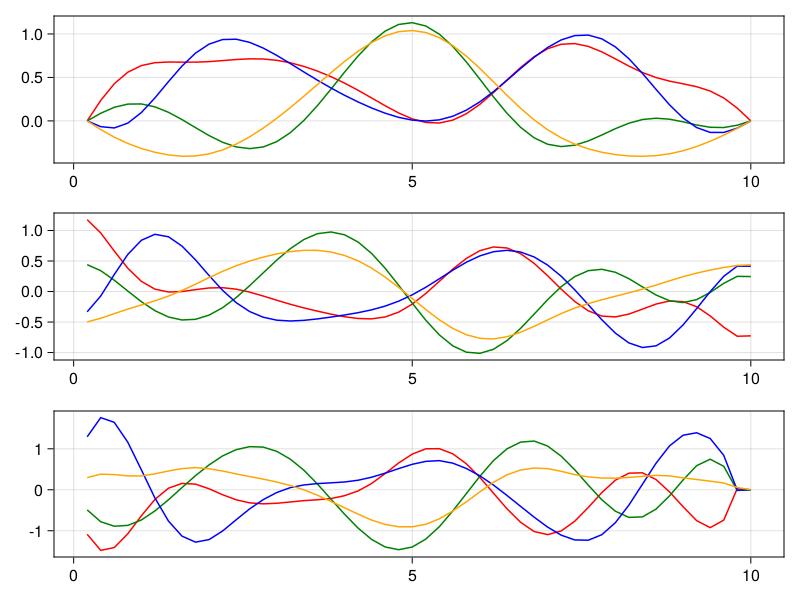

In [16]:
plot_control(rob_prob_2)

In [37]:
save("saved-pulses/single_qubit_gateset_R1e-5.jld2", rob_prob_2.trajectory)

# From 1.0 bound gate, no constraint, tighten R's

In [17]:
trajectory = copy(rob_prob_1.trajectory)
# Need random initial conditions to avoid local minima
# update!(trajectory, :a, random_a_guess(trajectory))
# update!(trajectory, :Ũ⃗, 2 * rand(trajectory.dims[:Ũ⃗], T) .- 1)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += QuadraticRegularizer(:dda, trajectory, 1e-3)
objective += QuadraticRegularizer(:a, trajectory, 1e-3)

update_bound!(trajectory, :a, Inf)
update_bound!(trajectory, :dda, Inf)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_3 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9999,
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [18]:
solve!(rob_prob_3; max_iter=200)

println("Fidelity: ", unitary_fidelity(rob_prob_3))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_3))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3007874e-03 2.16e-04 6.83e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  4.2964139e-03 1.33e-03 2.40e-02  -4.0 1.16e-02    -  1.00e+00 8.56e-01h  1


   2  4.2864883e-03 5.03e-05 2.46e-03  -4.0 2.85e-02    -  1.00e+00 1.00e+00h  1


   3  4.2566654e-03 1.57e-05 1.23e-03  -4.0 1.46e-02    -  1.00e+00 1.00e+00h  1


   4  4.2329287e-03 1.21e-05 5.47e-04  -4.0 1.23e-02    -  1.00e+00 1.00e+00h  1


   5  4.2300222e-03 1.64e-06 2.47e-04  -4.0 4.85e-03    -  1.00e+00 1.00e+00h  1


   6  4.2196050e-03 4.76e-07 3.35e-04  -4.0 3.59e-03    -  1.00e+00 1.00e+00h  1


   7  3.0714911e-03 2.79e-02 1.12e-01  -4.0 1.70e+00    -  1.00e+00 5.00e-01h  2


   8  2.9493988e-03 4.47e-03 2.74e-02  -4.0 3.84e-01    -  1.00e+00 1.00e+00h  1


   9  2.8108891e-03 2.92e-04 9.08e-04  -4.0 7.48e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7879660e-03 2.41e-04 3.97e-03  -4.0 7.46e-02    -  1.00e+00 1.00e+00h  1


  11  2.6862129e-03 2.15e-04 1.12e-03  -4.0 1.00e-01    -  1.00e+00 1.00e+00h  1


  12  2.6841884e-03 1.14e-04 1.08e-03  -4.0 7.03e-02    -  1.00e+00 1.00e+00h  1


  13  2.6357791e-03 5.54e-05 6.12e-04  -4.0 2.04e-02    -  1.00e+00 1.00e+00h  1


  14  2.5848796e-03 5.23e-05 1.50e-03  -4.0 4.01e-02    -  1.00e+00 1.00e+00h  1


  15  2.5772191e-03 2.34e-05 1.23e-03  -4.0 2.01e-02    -  1.00e+00 1.00e+00h  1


  16  2.5266066e-03 5.66e-05 1.42e-03  -4.0 2.06e-02    -  1.00e+00 1.00e+00h  1


  17  2.4839924e-03 3.88e-05 2.35e-03  -4.0 2.58e-02    -  1.00e+00 1.00e+00h  1


  18  2.4216475e-03 1.95e-04 3.11e-03  -4.0 4.30e-02    -  1.00e+00 1.00e+00h  1


  19  2.4094824e-03 2.26e-05 1.75e-03  -4.0 2.07e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3890817e-03 2.62e-06 1.13e-03  -4.0 1.49e-02    -  1.00e+00 1.00e+00H  1


  21  2.3831054e-03 3.90e-06 7.16e-04  -4.0 1.35e-02    -  1.00e+00 1.00e+00h  1


  22  2.3692560e-03 2.26e-07 8.41e-04  -4.0 6.79e-03    -  1.00e+00 1.00e+00H  1


  23  2.1413647e-03 4.04e-03 3.02e-02  -4.0 2.09e-01    -  1.00e+00 1.00e+00h  1


  24  2.2170967e-03 1.31e-03 7.15e-03  -4.0 1.11e-01    -  1.00e+00 1.00e+00h  1


  25  2.2501213e-03 2.86e-04 1.51e-03  -4.0 7.91e-02    -  1.00e+00 1.00e+00h  1


  26  2.2501281e-03 1.20e-04 1.04e-03  -4.0 4.69e-02    -  1.00e+00 1.00e+00h  1


  27  2.2305427e-03 5.75e-05 1.02e-03  -4.0 2.45e-02    -  1.00e+00 1.00e+00h  1


  28  2.2323017e-03 2.54e-05 1.88e-03  -4.0 2.61e-02    -  1.00e+00 1.00e+00h  1


  29  2.2333964e-03 1.24e-05 1.33e-03  -4.0 1.62e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.2312976e-03 4.24e-06 5.45e-04  -4.0 1.02e-02    -  1.00e+00 1.00e+00h  1


  31  2.2296680e-03 2.68e-06 3.68e-04  -4.0 6.06e-03    -  1.00e+00 1.00e+00h  1


  32  2.2291764e-03 7.49e-07 2.39e-04  -4.0 2.90e-03    -  1.00e+00 1.00e+00h  1


  33  2.2273855e-03 1.45e-07 2.13e-04  -4.0 2.06e-03    -  1.00e+00 1.00e+00h  1


  34  2.2255202e-03 4.20e-07 2.97e-04  -4.0 4.02e-03    -  1.00e+00 1.00e+00h  1


  35  2.1625430e-03 8.15e-04 1.47e-02  -4.0 1.86e-01    -  1.00e+00 1.00e+00h  1


  36  2.1220941e-03 3.38e-04 1.27e-02  -4.0 7.08e-02    -  1.00e+00 1.00e+00h  1


  37  2.0773787e-03 2.54e-04 2.80e-04  -4.0 5.56e-02    -  1.00e+00 1.00e+00h  1


  38  2.1439711e-03 5.44e-03 1.21e-02  -4.0 8.07e-01    -  1.00e+00 1.00e+00h  1


  39  2.1136070e-03 7.11e-03 1.47e-03  -3.7 8.99e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.0480220e-03 3.98e-03 1.00e-03  -3.7 6.40e-01    -  1.00e+00 1.00e+00h  1


  41  1.9544705e-03 3.50e-03 7.93e-04  -4.0 5.07e-01    -  1.00e+00 1.00e+00h  1


  42  2.2299979e-03 3.27e-03 2.67e-04  -4.0 4.23e-01    -  1.00e+00 1.00e+00h  1


  43  1.9870972e-03 1.59e-03 3.88e-04  -4.3 3.96e-01    -  1.00e+00 1.00e+00h  1


  44  1.9954868e-03 2.42e-03 4.57e-04  -4.0 2.82e-01    -  1.00e+00 1.00e+00h  1


  45  1.9546008e-03 1.05e-03 9.18e-05  -4.0 2.24e-01    -  1.00e+00 1.00e+00h  1


  46  1.9995495e-03 3.25e-04 1.89e-04  -4.0 9.87e-02    -  1.00e+00 1.00e+00h  1


  47  1.9504462e-03 2.18e-04 2.89e-04  -4.0 8.17e-02    -  1.00e+00 1.00e+00h  1


  48  1.9850678e-03 1.40e-04 2.13e-04  -4.0 5.32e-02    -  1.00e+00 1.00e+00h  1


  49  1.9663507e-03 5.45e-05 3.96e-04  -4.0 4.04e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.9783084e-03 8.80e-05 9.69e-04  -4.0 6.79e-02    -  1.00e+00 1.00e+00h  1


  51  1.9892933e-03 8.01e-05 5.42e-04  -4.0 4.88e-02    -  1.00e+00 1.00e+00h  1


  52  1.9798074e-03 1.06e-05 1.49e-04  -6.1 1.67e-02    -  1.00e+00 1.00e+00h  1


  53  1.9930534e-03 6.46e-05 2.61e-03  -4.0 4.64e-02    -  1.00e+00 1.00e+00h  1


  54  1.9815822e-03 2.48e-05 3.28e-04  -3.9 2.96e-02    -  1.00e+00 1.00e+00h  1


  55  1.9818625e-03 2.13e-06 1.41e-04  -5.9 7.34e-03    -  1.00e+00 1.00e+00h  1


  56  1.9794940e-03 2.18e-07 6.73e-04  -4.0 5.88e-03    -  1.00e+00 1.00e+00H  1


  57  1.9811466e-03 1.67e-06 1.70e-05  -4.0 4.49e-03    -  1.00e+00 1.00e+00h  1


  58  1.9808018e-03 1.51e-08 5.13e-05  -4.1 5.91e-04    -  1.00e+00 1.00e+00h  1


  59  1.9812857e-03 2.04e-08 4.14e-05  -4.0 6.18e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.9809883e-03 8.81e-09 3.04e-05  -4.1 5.16e-04    -  1.00e+00 1.00e+00h  1


  61  1.9810284e-03 2.71e-09 1.38e-05  -4.0 2.52e-04    -  1.00e+00 1.00e+00h  1


  62  1.9809660e-03 2.20e-09 2.37e-05  -4.0 2.96e-04    -  1.00e+00 1.00e+00h  1


  63  1.9741420e-03 6.09e-06 1.30e-03  -4.0 1.59e-02    -  1.00e+00 1.00e+00h  1


  64  1.9678191e-03 2.35e-05 3.96e-03  -4.0 2.97e-02    -  1.00e+00 1.00e+00h  1


  65  1.9666263e-03 2.80e-05 4.27e-03  -4.1 3.15e-02    -  1.00e+00 1.00e+00h  1


  66  1.9681948e-03 2.73e-05 4.33e-02  -4.1 9.00e-02    -  1.00e+00 1.25e-01h  4


  67  1.9846427e-03 1.71e-04 1.61e-01  -4.1 1.74e-01    -  1.00e+00 5.00e-01h  2


  68  1.9587237e-03 4.85e-04 2.36e-03  -4.1 1.44e-01    -  1.00e+00 1.00e+00h  1


  69  1.9718698e-03 4.83e-04 5.80e-03  -4.1 4.30e-01    -  1.00e+00 1.25e-01h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.0026082e-03 3.89e-04 1.13e-01  -4.1 1.32e-01    -  1.00e+00 5.00e-01h  2


  71  2.0014443e-03 4.25e-04 3.38e-03  -4.1 2.58e-01    -  1.00e+00 1.25e-01h  4


  72  2.0168855e-03 1.55e-03 9.18e-02  -4.1 4.42e-01    -  9.28e-01 5.00e-01h  2


  73  2.0042227e-03 1.48e-03 9.23e-04  -4.1 2.64e-01    -  1.00e+00 1.00e+00h  1


  74  1.9907814e-03 2.11e-04 8.23e-04  -4.1 1.34e-01    -  1.00e+00 1.00e+00h  1


  75  1.9916391e-03 2.23e-04 1.50e-02  -4.1 1.67e-01    -  1.00e+00 2.50e-01h  3


  76  1.9896930e-03 2.29e-04 2.78e-03  -4.1 4.76e-01    -  1.00e+00 3.12e-02h  6


  77  1.9892131e-03 2.28e-04 4.38e-02  -4.1 3.38e-01    -  1.00e+00 1.56e-02h  7


  78  1.9870944e-03 2.35e-04 4.42e-02  -4.1 1.41e+00    -  1.00e+00 7.81e-03h  8


  79  1.9844760e-03 2.57e-04 7.91e-03  -4.1 5.40e-01    -  1.00e+00 6.25e-02h  5


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.9721712e-03 2.60e-04 4.22e-02  -4.1 3.20e-01    -  1.00e+00 1.25e-01h  4


  81  1.9842091e-03 2.42e-04 2.84e-02  -4.1 2.36e-01    -  1.00e+00 1.25e-01h  4


  82  1.9825816e-03 2.41e-04 5.31e-02  -4.1 2.22e-01    -  1.00e+00 3.12e-02h  6


  83  1.9800583e-03 2.42e-04 1.08e-01  -4.1 3.03e+00    -  1.00e+00 7.81e-03h  8


  84  1.9779809e-03 2.51e-04 4.65e-02  -4.1 1.44e+00    -  1.00e+00 7.81e-03h  8


  85  2.0655368e-03 4.59e-03 6.40e-03  -4.1 2.19e-01    -  1.00e+00 1.00e+00w  1


  86  2.0407846e-03 5.15e-03 2.53e-03  -4.1 3.64e-01    -  1.00e+00 1.00e+00w  1


  87  2.0085660e-03 6.12e-03 1.75e-03  -4.1 4.35e-01    -  1.00e+00 1.00e+00w  1


  88  1.9764001e-03 2.53e-04 1.78e-02  -4.1 6.01e-01    -  1.00e+00 6.25e-02h  4


  89  1.9750028e-03 2.50e-04 2.75e-02  -4.1 2.43e-01    -  1.00e+00 3.12e-02h  6


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.9743102e-03 2.51e-04 1.88e-02  -4.1 9.49e-01    -  1.00e+00 7.81e-03h  8


  91  1.9714148e-03 2.66e-04 5.38e-02  -4.1 3.59e+00    -  1.00e+00 3.91e-03h  9


  92  1.9723030e-03 2.63e-04 4.12e-02  -4.1 3.53e-01    -  1.00e+00 1.56e-02h  7


  93  1.9726376e-03 2.63e-04 3.22e-02  -4.1 1.11e+00    -  1.00e+00 9.77e-04h 11


  94  1.9728865e-03 2.63e-04 4.28e-02  -4.1 1.19e+00    -  1.00e+00 3.91e-03h  9


  95  1.9732188e-03 2.63e-04 2.62e-02  -4.1 9.75e-01    -  1.00e+00 3.91e-03h  9


  96  1.9740484e-03 2.62e-04 1.19e-02  -4.1 8.23e-01    -  1.00e+00 7.81e-03h  8


  97  1.9681500e-03 1.00e-07 2.19e-03  -4.1 2.19e-03    -  1.00e+00 1.00e+00h  1


  98  1.9552558e-03 8.68e-04 1.73e-03  -4.0 1.21e-01    -  1.00e+00 1.00e+00h  1


  99  1.9551093e-03 2.38e-04 4.25e-04  -4.4 6.25e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9640713e-03 2.01e-04 7.25e-05  -4.0 5.77e-02    -  1.00e+00 1.00e+00h  1


 101  1.9691526e-03 8.87e-06 1.84e-04  -4.0 1.65e-02    -  1.00e+00 1.00e+00h  1


 102  1.9675513e-03 2.04e-06 1.64e-05  -4.8 7.71e-03    -  1.00e+00 1.00e+00h  1


 103  1.9946064e-03 4.53e-05 2.07e-03  -4.0 2.01e-02    -  1.00e+00 1.00e+00h  1


 104  1.9770555e-03 1.89e-05 4.50e-04  -3.9 1.38e-02    -  1.00e+00 1.00e+00h  1


 105  1.9732470e-03 1.21e-06 1.82e-04  -5.8 6.01e-03    -  1.00e+00 1.00e+00h  1


 106  1.9701716e-03 5.91e-07 6.15e-05  -5.8 2.93e-03    -  1.00e+00 1.00e+00h  1


 107  1.9496330e-03 2.37e-05 2.64e-05  -5.8 1.89e-02    -  1.00e+00 1.00e+00h  1


 108  2.2175769e-03 2.97e-03 6.99e-03  -4.0 2.08e-01    -  1.00e+00 1.00e+00h  1


 109  2.0496269e-03 9.70e-04 1.65e-03  -3.1 1.19e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.9854453e-03 2.04e-04 3.34e-04  -4.6 5.46e-02    -  1.00e+00 1.00e+00h  1


 111  1.9641801e-03 2.52e-05 1.82e-05  -4.6 1.94e-02    -  1.00e+00 1.00e+00h  1


 112  1.9609185e-03 4.25e-07 1.29e-05  -6.9 2.51e-03    -  1.00e+00 1.00e+00h  1


 113  2.0439762e-03 2.33e-04 4.71e-03  -4.0 5.44e-02    -  1.00e+00 1.00e+00h  1


 114  1.9932661e-03 8.05e-05 1.10e-03  -3.5 3.19e-02    -  1.00e+00 1.00e+00h  1


 115  1.9749123e-03 1.19e-05 2.39e-04  -5.3 1.25e-02    -  1.00e+00 1.00e+00h  1


 116  1.9694636e-03 9.84e-07 7.70e-05  -5.3 3.70e-03    -  1.00e+00 1.00e+00h  1


 117  1.9633375e-03 1.09e-06 4.64e-05  -5.3 4.28e-03    -  1.00e+00 1.00e+00h  1


 118  1.9478467e-03 5.86e-06 3.88e-05  -7.9 1.06e-02    -  1.00e+00 1.00e+00h  1


 119  1.9807603e-03 7.51e-06 3.21e+00  -4.0 2.19e-01    -  1.00e+00 1.58e-02H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.9867618e-03 2.68e-06 1.25e-01  -7.8 5.46e-03    -  9.63e-01 1.00e+00h  1


 121  1.7570805e-03 6.18e-03 5.25e-02  -7.8 2.97e-01    -  1.00e+00 1.00e+00h  1


 122  1.8229504e-03 1.55e-03 1.25e-02  -4.0 1.48e-01    -  1.00e+00 1.00e+00h  1


 123  1.8948571e-03 3.81e-04 3.62e-03  -4.0 7.53e-02    -  1.00e+00 1.00e+00h  1


 124  1.9355458e-03 1.13e-04 7.47e-04  -4.0 4.08e-02    -  1.00e+00 1.00e+00h  1


 125  1.9666045e-03 3.46e-05 5.71e-04  -4.0 2.22e-02    -  1.00e+00 1.00e+00h  1


 126  1.9617508e-03 8.22e-06 4.19e-04  -4.1 1.12e-02    -  1.00e+00 1.00e+00h  1


 127  1.9594296e-03 5.01e-07 5.34e-05  -6.1 3.10e-03    -  1.00e+00 1.00e+00h  1


 128  1.9702898e-03 1.12e-05 1.28e-03  -4.0 1.36e-02    -  1.00e+00 1.00e+00h  1


 129  1.9676784e-03 5.26e-06 3.03e-04  -3.9 8.57e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.9589426e-03 2.44e-06 2.98e-05  -5.9 6.49e-03    -  1.00e+00 1.00e+00h  1


 131  1.9764534e-03 1.11e-05 9.75e-04  -4.0 1.34e-02    -  1.00e+00 1.00e+00h  1


 132  1.9646444e-03 4.75e-06 1.34e-04  -4.0 8.95e-03    -  1.00e+00 1.00e+00h  1


 133  1.9628062e-03 8.05e-08 7.32e-05  -6.0 1.31e-03    -  1.00e+00 1.00e+00h  1


 134  1.9602460e-03 4.25e-07 3.16e-04  -4.0 3.41e-03    -  1.00e+00 1.00e+00h  1


 135  1.9570490e-03 5.51e-07 4.91e-04  -4.1 3.76e-03    -  1.00e+00 1.00e+00h  1


 136  1.9606276e-03 6.22e-07 3.49e-04  -4.0 2.71e-03    -  1.00e+00 1.00e+00h  1


 137  1.9588118e-03 1.18e-07 5.03e-05  -4.1 1.69e-03    -  1.00e+00 1.00e+00h  1


 138  1.9572930e-03 2.36e-07 1.83e-04  -4.0 2.47e-03    -  1.00e+00 1.00e+00h  1


 139  1.9424114e-03 1.34e-04 5.30e-03  -4.0 5.68e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.9481168e-03 4.04e-05 1.35e-03  -4.1 3.18e-02    -  1.00e+00 1.00e+00h  1


 141  1.9424853e-03 5.36e-06 1.31e-03  -4.1 1.11e-02    -  1.00e+00 1.00e+00h  1


 142  1.9466141e-03 4.37e-06 1.24e-03  -4.0 1.23e-02    -  1.00e+00 1.00e+00H  1


 143  1.9460630e-03 3.69e-06 1.59e-04  -4.0 7.42e-03    -  1.00e+00 1.00e+00h  1


 144  1.9455917e-03 3.75e-07 1.82e-04  -4.0 3.28e-03    -  1.00e+00 1.00e+00h  1


 145  1.9459494e-03 5.68e-08 8.34e-05  -4.0 1.43e-03    -  1.00e+00 1.00e+00h  1


 146  1.9458248e-03 7.86e-09 3.37e-05  -4.0 4.45e-04    -  1.00e+00 1.00e+00h  1


 147  1.9458308e-03 1.32e-10 3.41e-07  -4.0 6.83e-05    -  1.00e+00 1.00e+00h  1


 148  1.9458763e-03 6.68e-14 6.35e-07  -4.0 1.01e-04    -  1.00e+00 1.00e+00H  1


 149  1.9458763e-03 6.69e-14 6.24e-07  -4.0 2.29e-03    -  1.00e+00 1.53e-05h 17


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.9458763e-03 6.69e-14 1.46e-06  -4.1 4.08e-03    -  1.00e+00 1.82e-12h 40


 151  1.9425413e-03 8.92e-07 1.01e-04  -6.1 5.02e-03    -  1.00e+00 1.00e+00h  1


 152  2.0763057e-03 1.40e-03 2.05e-02  -4.0 1.89e-01    -  1.00e+00 1.00e+00h  1


 153  1.9985604e-03 3.83e-04 5.13e-03  -3.2 9.91e-02    -  1.00e+00 1.00e+00h  1


 154  1.9669464e-03 9.31e-05 1.29e-03  -4.8 4.87e-02    -  1.00e+00 1.00e+00h  1


 155  1.9543921e-03 2.30e-05 3.20e-04  -4.8 2.34e-02    -  1.00e+00 1.00e+00h  1


 156  1.9481392e-03 6.33e-06 7.48e-05  -4.8 1.17e-02    -  1.00e+00 1.00e+00h  1


 157  1.9444891e-03 1.23e-06 2.74e-05  -7.3 3.87e-03    -  1.00e+00 1.00e+00h  1


 158  2.0382862e-03 5.56e-04 8.49e-03  -4.0 7.62e-02    -  1.00e+00 1.00e+00h  1


 159  1.9827368e-03 1.75e-04 2.03e-03  -3.4 4.21e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.9603099e-03 3.52e-05 4.06e-04  -5.0 2.00e-02    -  1.00e+00 1.00e+00h  1


 161  1.9522406e-03 5.10e-06 1.69e-04  -5.0 6.67e-03    -  1.00e+00 1.00e+00h  1


 162  1.9485855e-03 1.06e-06 3.29e-05  -5.0 3.93e-03    -  1.00e+00 1.00e+00h  1


 163  1.9439342e-03 1.68e-06 7.13e-05  -7.6 4.05e-03    -  1.00e+00 1.00e+00h  1


 164  1.9394547e-03 2.50e-06 1.34e-02  -5.7 8.56e-03    -  1.00e+00 4.61e-01h  2


 165  2.0899325e-03 1.32e-03 6.25e-03  -4.0 1.14e-01    -  1.00e+00 1.00e+00h  1


 166  1.9983036e-03 4.25e-04 1.49e-03  -3.2 6.51e-02    -  1.00e+00 1.00e+00h  1


 167  1.9620895e-03 8.77e-05 3.16e-04  -4.8 2.97e-02    -  1.00e+00 1.00e+00h  1


 168  1.9496299e-03 1.17e-05 4.28e-05  -4.8 1.09e-02    -  1.00e+00 1.00e+00h  1


 169  1.9467175e-03 6.55e-07 2.77e-05  -7.2 2.63e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.9410400e-03 2.48e-06 3.39e-05  -7.2 5.23e-03    -  1.00e+00 1.00e+00h  1


 171  1.9367864e-03 2.11e-06 3.45e-03  -7.2 5.74e-03    -  1.00e+00 7.17e-01h  1


 172  2.1144877e-03 1.74e-03 7.26e-03  -4.0 1.42e-01    -  1.00e+00 1.00e+00f  1


 173  2.0056267e-03 5.67e-04 1.72e-03  -3.0 8.11e-02    -  1.00e+00 1.00e+00h  1


 174  1.9629957e-03 1.16e-04 3.50e-04  -4.6 3.69e-02    -  1.00e+00 1.00e+00h  1


 175  1.9489763e-03 1.42e-05 2.69e-05  -4.6 1.30e-02    -  1.00e+00 1.00e+00h  1


 176  1.9468677e-03 3.28e-07 1.97e-05  -6.9 2.07e-03    -  1.00e+00 1.00e+00h  1


 177  1.9423025e-03 1.51e-06 3.86e-05  -6.9 4.66e-03    -  1.00e+00 1.00e+00h  1


 178  2.1688477e-03 2.43e-03 1.42e-02  -4.0 1.80e-01    -  1.00e+00 1.00e+00h  1


 179  2.0363697e-03 7.02e-04 3.52e-03  -3.0 9.70e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.9805588e-03 1.69e-04 8.48e-04  -4.5 4.78e-02    -  1.00e+00 1.00e+00h  1


 181  1.9558363e-03 3.90e-05 1.64e-04  -4.5 2.31e-02    -  1.00e+00 1.00e+00h  1


 182  1.9490603e-03 3.11e-06 4.22e-05  -6.7 6.65e-03    -  1.00e+00 1.00e+00h  1


 183  1.9448666e-03 1.20e-06 4.05e-05  -6.7 4.48e-03    -  1.00e+00 1.00e+00h  1


 184  1.9353224e-03 5.66e-06 9.54e-06  -6.7 9.96e-03    -  1.00e+00 1.00e+00h  1


 185  2.1131896e-03 1.34e-03 7.57e-03  -4.0 1.53e-01    -  1.00e+00 1.00e+00h  1


 186  2.0029676e-03 4.53e-04 1.77e-03  -3.1 8.97e-02    -  1.00e+00 1.00e+00h  1


 187  1.9604787e-03 8.40e-05 3.35e-04  -4.6 3.71e-02    -  1.00e+00 1.00e+00h  1


 188  1.9488403e-03 1.14e-05 1.68e-04  -4.6 1.88e-02    -  1.00e+00 1.00e+00h  1


 189  1.9443293e-03 2.35e-06 9.16e-05  -6.9 5.46e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.9418119e-03 5.19e-07 3.12e-05  -6.9 2.73e-03    -  1.00e+00 1.00e+00h  1


 191  2.1333702e-03 1.19e-03 1.97e-02  -4.0 1.36e-01    -  1.00e+00 1.00e+00h  1


 192  2.0192778e-03 3.59e-04 4.89e-03  -3.0 7.41e-02    -  1.00e+00 1.00e+00h  1


 193  1.9727015e-03 1.06e-04 1.08e-03  -4.5 4.19e-02    -  1.00e+00 1.00e+00h  1


 194  1.9523644e-03 7.20e-05 7.35e-04  -4.5 2.54e-02    -  1.00e+00 1.00e+00h  1


 195  1.9515210e-03 1.78e-05 1.28e-04  -4.5 2.14e-02    -  1.00e+00 1.00e+00h  1


 196  1.9481716e-03 1.26e-06 7.78e-05  -6.8 5.01e-03    -  1.00e+00 1.00e+00h  1


 197  1.9403501e-03 1.00e-05 4.84e-05  -6.8 1.42e-02    -  1.00e+00 1.00e+00h  1


 198  1.9275466e-03 8.10e-05 2.27e-04  -6.8 3.42e-02    -  1.00e+00 1.00e+00h  1


 199  2.0080771e-03 7.02e-04 1.67e-03  -4.0 1.06e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9524501e-03 3.32e-04 1.58e-04  -3.6 7.25e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   1.9524500729423524e-03    1.9524500729423524e-03
Dual infeasibility......:   1.5793560387014575e-04    1.5793560387014575e-04
Constraint violation....:   3.3211053246150896e-04    3.3211053246150896e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5444495572867452e-04    2.5444495572867452e-04
Overall NLP error.......:   3.3211053246150896e-04    3.3211053246150896e-04


Number of objective function evaluations             = 439
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 440
Number of inequality constraint evaluations          = 440
Number of equality constraint Jacob

In [45]:
println("max(a): ", maximum(rob_prob_3.trajectory[:a]))
println("max(dda): ", maximum(rob_prob_3.trajectory[:dda]))

max(a): 0.8783286699999069
max(dda): 0.6602514132027589


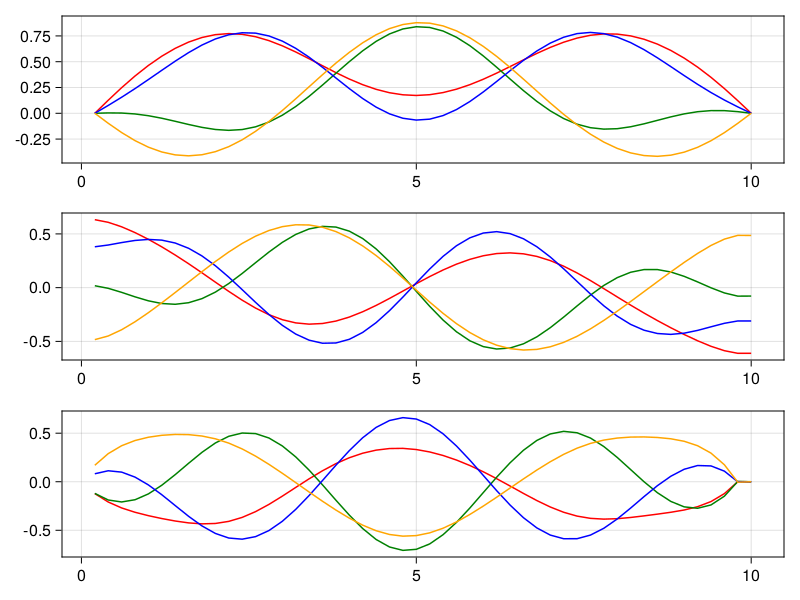

In [19]:
plot_control(rob_prob_3)

In [33]:
save("saved-pulses/single_qubit_gateset_R1e-3.jld2", rob_prob_3.trajectory)

In [58]:
writedlm("saved-pulses/a_single_qubit_gateset_R1e-3.csv", rob_prob_3.trajectory[:a], ",")

# From 1.0 bound gate, no constraint, loosen R

In [20]:
trajectory = copy(rob_prob_1.trajectory)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += QuadraticRegularizer(:dda, trajectory, 1e-6)
objective += QuadraticRegularizer(:a, trajectory, 1e-6)

update_bound!(trajectory, :a, Inf)
update_bound!(trajectory, :dda, Inf)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_4 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9999,
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [21]:
solve!(rob_prob_4; max_iter=200)

println("Fidelity: ", unitary_fidelity(rob_prob_4))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_4))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5131790e-03 2.16e-04 6.86e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  3.5086305e-03 1.33e-03 2.40e-02  -4.0 1.16e-02    -  1.00e+00 8.56e-01h  1


   2  3.4816959e-03 5.26e-05 2.49e-03  -4.0 3.40e-02    -  1.00e+00 1.00e+00h  1


   3  3.4414640e-03 1.56e-05 1.23e-03  -4.0 1.53e-02    -  1.00e+00 1.00e+00h  1


   4  3.3985764e-03 1.57e-05 5.66e-04  -4.0 1.73e-02    -  1.00e+00 1.00e+00h  1


   5  3.3936910e-03 2.06e-06 3.04e-04  -4.0 5.35e-03    -  1.00e+00 1.00e+00h  1


   6  3.3719495e-03 1.36e-06 4.99e-04  -4.0 7.89e-03    -  1.00e+00 1.00e+00h  1


   7  2.4648367e-03 4.19e-02 3.30e-01  -4.0 1.85e+00    -  1.00e+00 7.49e-01h  1


   8  1.9683105e-03 1.01e-02 5.10e-02  -4.0 6.56e-01    -  1.00e+00 1.00e+00h  1


   9  1.7408275e-03 8.79e-04 2.80e-03  -4.0 1.15e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7113952e-03 4.68e-04 8.47e-04  -4.0 1.21e-01    -  1.00e+00 1.00e+00h  1


  11  1.4793695e-03 1.36e-04 7.80e-02  -3.5 1.68e-01    -  1.00e+00 7.35e-01H  1


  12  1.0395598e-03 2.13e-03 2.12e-02  -4.4 2.77e-01    -  9.47e-01 1.00e+00h  1


  13  1.0508010e-03 1.51e-03 2.54e-01  -5.5 1.23e+00    -  1.00e+00 1.78e-02H  1


  14  1.1539968e-03 3.91e-02 2.49e-02  -4.6 1.15e+00    -  9.06e-01 1.00e+00h  1


  15  5.2222089e-04 4.42e-02 1.74e-02  -6.7 2.56e+00    -  5.21e-01 2.50e-01h  3


  16  5.2150695e-04 4.42e-02 1.74e-02 -11.0 1.64e-01    -  1.00e+00 1.32e-03h  1


  17  5.2010744e-04 4.41e-02 1.78e-02 -10.1 3.45e-01    -  1.00e+00 1.15e-03h  1


  18  3.7255732e-04 5.28e-03 9.39e-04  -9.1 3.98e-01    -  3.19e-01 1.00e+00h  1


  19  3.7100747e-04 5.26e-03 2.48e-03  -9.1 2.25e-01    -  1.00e+00 3.96e-03h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5694662e-04 4.07e-03 1.85e-04  -8.9 4.11e-01    -  8.93e-01 1.00e+00h  1


  21  1.1399325e-04 9.08e-04 1.45e-05  -9.5 1.13e-01    -  1.00e+00 1.00e+00h  1


  22  4.3094117e-04 2.49e-02 1.38e-02  -4.0 4.32e+00    -  1.00e+00 2.50e-01f  3


  23  1.4097636e-04 1.31e-02 4.67e-05  -3.0 7.95e-01    -  1.00e+00 1.00e+00h  1


  24  2.8122554e-04 8.49e-03 9.83e-04  -3.0 4.71e-01    -  1.00e+00 1.00e+00h  1


  25  1.3740143e-04 2.14e-03 2.12e-04  -4.5 2.03e-01    -  1.00e+00 1.00e+00h  1


  26  9.9983422e-05 7.13e-04 3.44e-05  -4.5 1.08e-01    -  1.00e+00 1.00e+00h  1


  27  8.7634936e-05 2.06e-04 1.45e-04  -4.0 5.69e-02    -  1.00e+00 1.00e+00h  1


  28  1.1335810e-04 7.31e-04 6.81e-04  -4.0 1.07e-01    -  1.00e+00 1.00e+00h  1


  29  8.9730127e-05 3.52e-04 2.82e-04  -3.8 7.07e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.1754077e-05 6.70e-05 2.41e-04  -5.7 5.88e-02    -  1.00e+00 1.00e+00h  1


  31  9.5877482e-05 2.99e-05 2.65e-02  -4.0 5.02e-02    -  1.00e+00 8.47e-01H  1


  32  9.2673165e-05 5.48e-05 1.23e-04  -4.0 4.26e-02    -  1.00e+00 1.00e+00f  1


  33  9.0562134e-05 8.73e-06 5.12e-04  -4.0 8.34e-03    -  1.00e+00 1.00e+00h  1


  34  9.4657292e-05 1.37e-05 8.10e-04  -4.0 1.44e-02    -  1.00e+00 1.00e+00h  1


  35  9.3270223e-05 1.10e-05 3.53e-02  -4.0 1.90e-02    -  1.00e+00 5.00e-01h  2


  36  9.1041782e-05 9.00e-06 4.92e-04  -4.0 9.42e-03    -  1.00e+00 1.00e+00h  1


  37  9.1319762e-05 1.65e-07 9.76e-05  -6.0 1.68e-03    -  1.00e+00 1.00e+00h  1


  38  9.3976865e-05 1.30e-05 1.59e-03  -4.0 1.27e-02    -  1.00e+00 1.00e+00h  1


  39  9.2262983e-05 5.26e-06 2.46e-04  -4.0 7.86e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  9.2084997e-05 2.12e-08 5.90e-05  -6.0 5.54e-04    -  1.00e+00 1.00e+00h  1


  41  9.0394941e-05 2.05e-06 8.72e-04  -4.0 7.07e-03    -  1.00e+00 1.00e+00h  1


  42  9.1575811e-05 9.98e-07 9.27e-05  -4.0 4.76e-03    -  1.00e+00 1.00e+00h  1


  43  9.1588055e-05 3.25e-08 8.94e-05  -4.1 9.90e-04    -  1.00e+00 1.00e+00h  1


  44  9.1601372e-05 1.21e-08 2.66e-05  -4.0 4.85e-04    -  1.00e+00 1.00e+00h  1


  45  9.1576466e-05 4.81e-10 1.48e-06  -4.0 1.74e-04    -  1.00e+00 1.00e+00h  1


  46  8.6991483e-05 9.86e-06 1.77e-03  -4.0 2.50e-02    -  1.00e+00 1.00e+00h  1


  47  8.7918244e-05 9.84e-07 1.30e-03  -4.0 4.33e-03    -  1.00e+00 1.00e+00h  1


  48  8.7821207e-05 8.35e-08 2.80e-04  -4.0 2.12e-03    -  1.00e+00 1.00e+00h  1


  49  8.6394087e-05 1.61e-06 6.40e-04  -4.0 1.01e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.0165945e-05 1.23e-03 5.43e-02  -4.0 1.12e+00    -  1.00e+00 2.50e-01h  3


  51  7.4406806e-05 2.08e-05 1.31e-02  -4.0 3.72e-02    -  1.00e+00 1.00e+00h  1


  52  7.0779481e-05 3.29e-05 3.69e-03  -4.0 4.92e-02    -  1.00e+00 1.00e+00h  1


  53  7.3433046e-05 1.66e-05 3.41e-03  -4.0 3.19e-02    -  1.00e+00 1.00e+00h  1


  54  7.1941770e-05 7.66e-06 1.73e-03  -4.0 1.80e-02    -  1.00e+00 1.00e+00h  1


  55  6.9753974e-05 2.28e-06 1.56e-03  -4.0 3.45e-02    -  1.00e+00 1.00e+00H  1


  56  7.0789299e-05 1.38e-04 4.00e-02  -4.0 1.83e-01    -  1.00e+00 5.00e-01h  2


  57  7.3331798e-05 1.51e-04 3.78e-01  -4.1 3.33e-01    -  1.00e+00 1.25e-01h  4


  58  9.7393494e-05 6.31e-03 2.52e-01  -4.1 1.32e+00    -  1.00e+00 5.00e-01h  2


  59  7.6549279e-05 6.44e-03 4.98e-01  -4.1 7.68e+00    -  1.00e+00 3.12e-02h  6


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.0249896e-05 4.59e-03 7.19e-02  -4.1 5.92e-01    -  1.00e+00 5.00e-01h  2


  61  7.1203817e-05 6.22e-03 3.88e-01  -4.1 2.20e+01    -  1.00e+00 1.56e-02h  7


  62  8.4210198e-05 5.46e-03 4.20e-01  -4.1 8.25e-01    -  1.00e+00 1.25e-01h  4


  63  8.6022592e-05 5.30e-03 2.13e-01  -4.1 2.45e+00    -  1.00e+00 1.25e-01h  4


  64  7.4239602e-05 5.69e-03 1.96e-01  -4.1 1.43e+00    -  1.00e+00 2.50e-01h  3


  65  7.0154164e-05 5.70e-03 3.33e-01  -4.1 3.44e+01    -  1.00e+00 1.95e-03h 10


  66  7.0048246e-05 5.70e-03 3.22e-01  -4.1 8.97e+01    -  1.00e+00 1.22e-04h 14


  67  7.5636547e+02 2.57e+01 1.54e+00  -4.1 6.36e+01    -  1.00e+00 1.00e+00w  1


  68  3.9664884e+01 1.46e+01 9.91e+00  -4.1 5.75e+01    -  1.62e-02 1.00e+00w  1


  69  3.2147627e+00 4.40e+00 3.67e+00  -4.1 1.94e+01    -  1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.9975578e-05 5.70e-03 3.40e-01  -4.1 9.75e+00    -  1.00e+00 1.22e-04h 13


  71  6.2991711e-05 9.43e-04 8.82e-04  -4.1 2.24e-01    -  1.00e+00 1.00e+00h  1


  72  4.8718411e-05 3.27e-04 1.25e-03  -4.0 7.97e-02    -  1.00e+00 1.00e+00h  1


  73  4.7860016e-05 1.32e-04 2.89e-04  -4.0 6.08e-02    -  1.00e+00 1.00e+00h  1


  74  4.6824313e-05 1.00e-04 3.62e-04  -4.0 5.30e-02    -  1.00e+00 1.00e+00h  1


  75  4.7368458e-05 5.34e-05 2.74e-04  -4.0 3.39e-02    -  1.00e+00 1.00e+00h  1


  76  4.6543761e-05 2.07e-05 5.42e-04  -4.0 1.83e-02    -  1.00e+00 1.00e+00h  1


  77  4.7374365e-05 1.70e-05 1.03e-03  -4.0 2.26e-02    -  1.00e+00 1.00e+00h  1


  78  4.7000243e-05 1.62e-05 5.39e-04  -4.0 2.09e-02    -  1.00e+00 1.00e+00h  1


  79  4.6740455e-05 6.92e-06 8.78e-05  -4.1 1.29e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.6868090e-05 6.67e-07 1.19e-04  -4.0 3.40e-03    -  1.00e+00 1.00e+00h  1


  81  4.6777537e-05 1.42e-07 3.98e-05  -4.0 1.77e-03    -  1.00e+00 1.00e+00h  1


  82  4.6773356e-05 4.57e-09 6.68e-06  -4.0 3.67e-04    -  1.00e+00 1.00e+00h  1


  83  4.6746061e-05 4.28e-10 1.27e-06  -4.0 1.70e-04    -  1.00e+00 1.00e+00h  1


  84  4.6578946e-05 1.04e-08 4.41e-05  -4.0 9.31e-04    -  1.00e+00 1.00e+00h  1


  85  4.4196964e-05 3.12e-06 7.43e-04  -4.0 1.92e-02    -  1.00e+00 1.00e+00h  1


  86  4.5820130e-05 1.67e-04 1.19e-01  -4.0 9.71e-01    -  1.00e+00 1.25e-01h  4


  87  3.9350909e-05 6.00e-05 2.16e-03  -4.2 6.19e-02    -  1.00e+00 1.00e+00h  1


  88  5.4591013e-05 1.84e-04 4.24e-01  -4.0 3.14e-01    -  1.00e+00 2.50e-01h  3


  89  4.6225182e-05 5.11e-05 2.04e-01  -4.9 2.65e-01    -  1.00e+00 1.71e-01H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.1545321e-05 1.50e-04 9.80e-02  -4.9 1.22e-01    -  8.89e-01 1.00e+00h  1


  91  6.6628786e-05 5.27e-04 8.23e-01  -4.9 2.73e+01    -  1.00e+00 7.81e-03h  8


  92  4.7002328e-05 8.36e-04 5.44e-02  -4.9 6.25e-01    -  9.77e-01 5.00e-01h  2


  93  4.4588543e-05 7.67e-04 3.57e-02  -4.9 4.50e-01    -  1.00e+00 5.00e-01h  2


  94  4.4493681e-05 1.23e-06 4.59e-03  -4.9 4.60e-03    -  1.00e+00 9.98e-01h  1


  95  3.4540462e-05 9.25e-05 7.06e-04  -7.2 2.71e-02    -  9.71e-01 1.00e+00h  1


  96  3.3501438e-05 5.91e-05 7.77e-06  -8.4 3.93e-02    -  1.00e+00 1.00e+00h  1


  97  4.1531783e-04 2.18e-02 7.90e-02  -4.0 2.25e+00    -  1.00e+00 2.50e-01f  3


  98  1.1708247e-04 6.74e-03 4.70e-04  -2.9 3.34e-01    -  1.00e+00 1.00e+00h  1


  99  5.9277965e-05 2.29e-03 2.03e-04  -4.3 2.53e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0772933e-05 2.22e-03 7.26e-05  -4.3 2.54e-01    -  1.00e+00 1.00e+00h  1


 101  3.8121598e-05 6.00e-04 4.38e-05  -4.3 1.08e-01    -  1.00e+00 1.00e+00h  1


 102  3.4750185e-05 2.98e-04 1.48e-04  -4.3 7.61e-02    -  1.00e+00 1.00e+00h  1


 103  3.4751424e-05 4.88e-05 2.14e-05  -6.5 2.98e-02    -  1.00e+00 1.00e+00h  1


 104  3.4919758e-05 5.58e-06 8.39e-06  -6.5 1.04e-02    -  1.00e+00 1.00e+00h  1


 105  2.0259844e-04 8.78e-03 3.64e-02  -4.0 5.46e-01    -  1.00e+00 1.00e+00h  1


 106  8.4993626e-05 2.31e-03 9.12e-03  -2.9 2.80e-01    -  1.00e+00 1.00e+00h  1


 107  6.0021478e-05 9.49e-04 2.71e-03  -4.3 1.75e-01    -  1.00e+00 1.00e+00h  1


 108  4.2962076e-05 3.71e-04 7.19e-05  -4.3 1.18e-01    -  1.00e+00 1.00e+00h  1


 109  3.8797702e-05 7.06e-05 1.06e-04  -6.5 2.58e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7794435e-05 2.07e-05 2.08e-03  -6.5 4.94e-03    -  1.00e+00 7.26e-01h  1


 111  3.6050461e-05 4.36e-06 2.05e-05  -6.5 7.52e-03    -  1.00e+00 1.00e+00h  1


 112  3.3707116e-05 8.86e-06 9.80e-05  -6.4 1.61e-02    -  9.86e-01 1.00e+00h  1


 113  3.1244114e-05 2.04e-05 1.59e-04  -8.3 2.47e-01    -  1.00e+00 8.51e-02h  1


 114  3.0997413e-05 2.76e-04 1.94e-03 -10.6 2.33e-01    -  1.00e+00 5.00e-01h  2


 115  2.8938602e-04 1.97e-02 7.19e-04  -4.0 9.28e-01    -  1.00e+00 1.00e+00f  1


 116  8.6749392e-05 7.70e-03 1.99e-04  -3.6 4.07e-01    -  1.00e+00 1.00e+00h  1


 117  7.9864910e-05 9.63e-03 1.64e-04  -3.6 6.45e-01    -  1.00e+00 1.00e+00h  1


 118  3.8968431e-05 6.43e-03 8.11e-05  -3.6 4.64e-01    -  1.00e+00 1.00e+00h  1


 119  3.8180722e-05 2.18e-03 1.26e-04  -3.6 2.69e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.2160108e-05 2.98e-04 2.49e-05  -5.5 8.12e-02    -  1.00e+00 1.00e+00h  1


 121  3.1484869e-05 1.31e-05 9.00e-06  -5.5 1.59e-02    -  1.00e+00 1.00e+00h  1


 122  2.4718712e-04 1.38e-02 2.25e-02  -4.0 6.45e-01    -  1.00e+00 1.00e+00h  1


 123  1.0116859e-04 3.69e-03 5.66e-03  -3.0 3.34e-01    -  1.00e+00 1.00e+00h  1


 124  5.7150167e-05 1.01e-03 1.79e-03  -4.5 1.33e-01    -  1.00e+00 1.00e+00h  1


 125  4.3528236e-05 3.86e-04 8.86e-05  -4.5 1.37e-01    -  1.00e+00 1.00e+00h  1


 126  3.4845062e-05 1.54e-04 1.34e-04  -4.5 1.08e-01    -  1.00e+00 1.00e+00h  1


 127  3.2513136e-05 3.75e-05 1.18e-04  -6.7 2.46e-02    -  1.00e+00 1.00e+00h  1


 128  3.1467659e-05 5.76e-06 2.91e-05  -6.7 1.09e-02    -  1.00e+00 1.00e+00h  1


 129  4.6014814e-04 1.47e-02 3.39e-02  -4.0 5.44e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1865364e-04 4.05e-03 8.39e-03  -2.6 2.84e-01    -  1.00e+00 1.00e+00h  1


 131  4.4831776e-05 9.61e-04 2.01e-03  -3.9 1.34e-01    -  1.00e+00 1.00e+00h  1


 132  2.9337413e-05 4.72e-04 8.05e-04  -3.9 1.29e-01    -  1.00e+00 1.00e+00h  1


 133  3.0606913e-05 1.33e-04 3.26e-04  -4.0 3.05e-02    -  1.00e+00 1.00e+00h  1


 134  3.0948951e-05 1.98e-06 9.28e-05  -4.0 4.61e-03    -  1.00e+00 1.00e+00h  1


 135  3.0788629e-05 1.84e-05 1.52e-03  -4.0 1.33e-02    -  1.00e+00 1.00e+00h  1


 136  3.0396251e-05 8.11e-06 3.44e-04  -4.0 1.19e-02    -  1.00e+00 1.00e+00h  1


 137  3.1022680e-05 6.96e-06 1.18e-02  -4.0 1.65e-02    -  1.00e+00 2.50e-01h  3


 138  3.0731317e-05 9.09e-07 2.86e-04  -4.1 4.96e-03    -  1.00e+00 1.00e+00h  1


 139  3.0639978e-05 1.36e-06 5.36e-04  -4.0 6.44e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.0794765e-05 5.72e-07 5.73e-05  -4.0 3.49e-03    -  1.00e+00 1.00e+00h  1


 141  3.0761861e-05 9.17e-09 1.12e-05  -4.0 5.37e-04    -  1.00e+00 1.00e+00h  1


 142  3.0758557e-05 3.44e-10 5.99e-07  -4.0 1.35e-04    -  1.00e+00 1.00e+00h  1


 143  3.0736993e-05 1.17e-09 1.80e-05  -4.0 2.93e-04    -  1.00e+00 1.00e+00h  1


 144  3.0293968e-05 1.84e-07 2.26e-04  -4.0 3.28e-03    -  1.00e+00 1.00e+00h  1


 145  2.9990658e-05 4.87e-07 6.47e-04  -4.0 6.95e-03    -  1.00e+00 1.00e+00h  1


 146  2.9879414e-05 1.04e-07 4.00e-04  -4.0 3.40e-03    -  1.00e+00 1.00e+00h  1


 147  2.9606021e-05 1.54e-07 5.22e-04  -4.0 3.13e-03    -  1.00e+00 1.00e+00h  1


 148  2.9155318e-05 1.28e-06 7.46e-04  -4.0 1.28e-02    -  1.00e+00 1.00e+00h  1


 149  2.9037130e-05 7.12e-07 1.01e-03  -4.0 8.39e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.9052002e-05 8.98e-08 1.39e-04  -4.0 2.85e-03    -  1.00e+00 1.00e+00h  1


 151  2.8998999e-05 3.28e-08 2.15e-04  -4.0 1.68e-03    -  1.00e+00 1.00e+00h  1


 152  2.8982209e-05 3.45e-09 3.18e-05  -4.0 7.65e-04    -  1.00e+00 1.00e+00h  1


 153  3.0747086e-05 3.29e-10 2.40e-05  -4.0 9.44e-02    -  1.00e+00 1.00e+00H  1


 154  3.7582902e-05 6.68e-05 8.71e-03  -4.0 1.31e-01    -  1.00e+00 1.00e+00h  1


 155  3.4639213e-05 4.74e-04 2.34e-03  -4.1 2.57e-01    -  1.00e+00 1.00e+00h  1


 156  3.2242058e-05 7.11e-04 4.46e-01  -4.1 1.47e+00    -  1.00e+00 1.25e-01h  4


 157  5.7339422e-05 8.54e-05 6.01e-03  -4.1 6.06e-02    -  1.00e+00 1.00e+00h  1


 158  1.2123033e-04 4.93e-05 4.47e-02  -4.1 4.49e-01    -  1.00e+00 8.68e-01H  1


 159  9.7330783e-05 6.59e-05 3.93e-01  -4.1 3.05e+00    -  1.00e+00 3.12e-02h  6


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.6827198e-05 6.42e-05 4.16e-01  -4.1 5.33e-01    -  1.00e+00 1.25e-01h  4


 161  7.8286683e-05 7.03e-05 4.29e-01  -4.1 1.15e+01    -  1.00e+00 3.91e-03h  9


 162  6.5476926e-05 7.61e-05 4.45e-01  -4.1 1.03e+00    -  1.00e+00 3.12e-02h  6


 163  6.2555067e-05 7.68e-05 1.90e-02  -4.1 4.44e+01    -  1.00e+00 2.44e-04h 13


 164  4.5872783e-05 4.87e-04 6.69e-01  -4.1 1.25e+02    -  1.96e-01 9.77e-04h 11


 165  5.0783387e-05 7.52e-04 1.25e+00  -4.1 2.98e+01    -  1.00e+00 1.56e-02h  7


 166  4.6684264e-05 8.11e-04 4.88e-01  -4.1 1.90e+00    -  1.00e+00 1.25e-01h  4


 167  4.5693705e-05 8.86e-04 4.13e-01  -4.1 1.18e+01    -  1.00e+00 3.91e-03h  9


 168  9.0391227e-05 9.48e-04 3.14e-01  -4.1 1.47e+00    -  1.00e+00 2.50e-01h  3


 169  1.4763751e+04 1.38e+02 1.48e+01  -4.1 1.88e+02    -  1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.4190150e+04 1.37e+02 1.43e+01  -4.1 1.03e+02    -  1.00e+00 1.02e-02w  1


 171  3.5812426e+03 1.01e+02 2.51e+02  -4.1 1.40e+02    -  1.00e+00 1.00e+00w  1


 172  7.3911525e-05 1.87e-03 3.82e-01  -4.1 6.67e+01    -  1.00e+00 1.95e-03h  9


 173  4.7698906e-05 4.08e-04 3.86e-03  -4.1 1.01e-01    -  1.00e+00 1.00e+00h  1


 174  3.7519584e-05 1.83e-04 3.02e-03  -4.1 7.10e-02    -  1.00e+00 1.00e+00h  1


 175  4.1079215e-05 8.36e-05 6.48e-04  -4.1 5.35e-02    -  1.00e+00 1.00e+00h  1


 176  4.1793676e-05 1.10e-05 1.37e-04  -6.2 1.26e-02    -  1.00e+00 1.00e+00h  1


 177  4.0908239e-05 1.12e-06 3.59e-05  -6.2 1.60e-02    -  1.00e+00 1.00e+00h  1


 178  3.9710617e-05 1.90e-04 3.00e-05  -6.2 1.02e-01    -  1.00e+00 1.00e+00h  1


 179  3.3716430e-05 3.45e-04 5.60e-05  -6.2 1.88e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.1790084e-05 1.29e-04 2.59e-05  -6.2 1.55e-01    -  1.00e+00 1.00e+00h  1


 181  2.3500070e-05 1.29e-04 4.42e+00  -4.0 1.38e+00    -  1.00e+00 5.31e-04H  1


 182  2.3479228e-05 1.24e-05 1.60e-02  -6.8 3.99e-02    -  9.96e-01 1.00e+00h  1


 183  2.2195022e-05 4.16e-06 3.49e-04 -11.0 1.26e-02    -  1.77e-03 1.00e+00h  1


 184  1.7362554e-05 8.73e-04 1.87e-05 -11.0 2.24e-01    -  1.00e+00 1.00e+00h  1


 185  1.5874808e-05 8.25e-04 1.76e-05  -8.2 2.19e-01    -  1.00e+00 6.20e-02h  1


 186  1.4441028e-05 2.81e-04 3.25e-06  -9.5 8.23e-02    -  1.00e+00 1.00e+00h  1


 187  2.4835953e-04 2.15e-02 2.84e-02  -4.0 6.44e+00    -  1.00e+00 1.25e-01f  4


 188  5.5883554e-05 9.39e-03 7.26e-05  -3.0 5.32e-01    -  1.00e+00 1.00e+00h  1


 189  2.0975108e-05 1.86e-03 3.10e-05  -4.5 2.60e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.0128467e-05 1.46e-03 9.28e-05  -4.5 2.29e-01    -  1.00e+00 1.00e+00h  1


 191  1.9086525e-05 9.03e-04 1.36e-05  -4.5 1.65e-01    -  1.00e+00 1.00e+00h  1


 192  1.8250059e-05 1.73e-05 1.67e-05  -4.5 3.06e-02    -  1.00e+00 1.00e+00h  1


 193  2.1848395e-04 1.52e-02 2.43e-02  -4.0 7.68e-01    -  1.00e+00 1.00e+00h  1


 194  6.9793820e-05 4.15e-03 6.27e-03  -2.9 3.91e-01    -  1.00e+00 1.00e+00h  1


 195  8.6480899e-05 3.72e-03 2.35e-03  -4.3 4.44e-01    -  1.00e+00 1.00e+00h  1


 196  4.1597139e-05 1.36e-03 6.04e-04  -4.3 2.01e-01    -  1.00e+00 1.00e+00h  1


 197  3.1221820e-05 5.82e-04 2.97e-04  -4.3 1.06e-01    -  1.00e+00 1.00e+00h  1


 198  2.6665373e-05 1.67e-04 1.30e-04  -4.3 5.44e-02    -  1.00e+00 1.00e+00h  1


 199  2.4733929e-05 1.13e-05 7.58e-05  -6.5 3.10e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2710607e-05 4.37e-06 1.45e-05  -6.5 1.63e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   2.2710607362796996e-05    2.2710607362796996e-05
Dual infeasibility......:   1.4505127048969900e-05    1.4505127048969900e-05
Constraint violation....:   4.3667805448427410e-06    4.3667805448427410e-06
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3532010407118149e-06    1.3532010407118149e-06
Overall NLP error.......:   9.8646798959288191e-05    9.8646798959288191e-05


Number of objective function evaluations             = 400
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 427
Number of inequality constraint evaluations          = 427
Number of equality constraint Jacob

In [46]:
println("max(a): ", maximum(rob_prob_4.trajectory[:a]))
println("max(dda): ", maximum(rob_prob_4.trajectory[:dda]))

max(a): 1.2240120921287572
max(dda): 3.2214603741315355


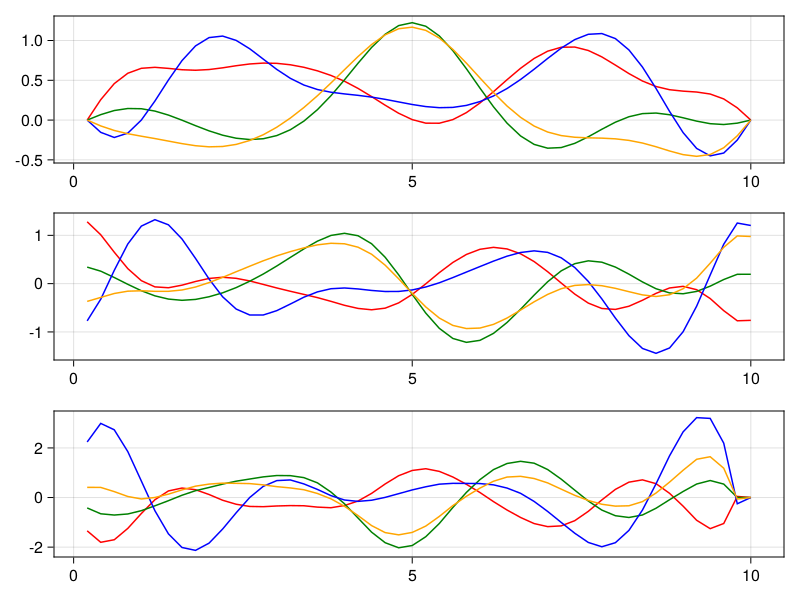

In [22]:
plot_control(rob_prob_4)

In [34]:
save("saved-pulses/single_qubit_gateset_R1e-6.jld2", rob_prob_4.trajectory)

In [59]:
writedlm("saved-pulses/a_single_qubit_gateset_R1e-6.csv", rob_prob_4.trajectory[:a], ",")

# From 1.0 bound gate, no constraint, tightest constraint

In [24]:
trajectory = copy(rob_prob_1.trajectory)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += QuadraticRegularizer(:dda, trajectory, 1e-2)
objective += QuadraticRegularizer(:a, trajectory, 1e-2)

update_bound!(trajectory, :a, Inf)
update_bound!(trajectory, :dda, Inf)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_5 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9999,
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [25]:
solve!(rob_prob_5; max_iter=200)

println("Fidelity: ", unitary_fidelity(rob_prob_5))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_5))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1396358e-02 2.16e-04 6.60e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  1.1393053e-02 1.33e-03 2.40e-02  -4.0 1.16e-02    -  1.00e+00 8.56e-01h  1


   2  1.1231538e-02 6.66e-05 2.19e-03  -4.0 7.57e-02    -  1.00e+00 1.00e+00h  1


   3  1.0946607e-02 8.35e-05 1.10e-03  -4.0 1.37e-01    -  1.00e+00 1.00e+00h  1


   4  1.0679510e-02 6.66e-04 1.24e-03  -4.0 3.03e-01    -  1.00e+00 1.00e+00h  1


   5  1.0550690e-02 4.42e-04 1.92e-03  -4.0 1.98e-01    -  1.00e+00 1.00e+00h  1


   6  1.0513174e-02 1.69e-04 1.32e-03  -4.0 7.26e-02    -  1.00e+00 1.00e+00h  1


   7  1.0590573e-02 8.58e-05 7.85e-04  -4.0 5.72e-02    -  1.00e+00 1.00e+00h  1


   8  1.0583617e-02 1.05e-05 3.04e-04  -4.0 2.02e-02    -  1.00e+00 1.00e+00h  1


   9  1.0657139e-02 4.87e-06 1.83e-03  -4.0 2.27e-02    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0626667e-02 9.41e-06 1.46e-03  -4.0 1.16e-02    -  1.00e+00 1.00e+00h  1


  11  1.0607860e-02 1.56e-05 1.37e-03  -4.0 2.28e-02    -  1.00e+00 1.00e+00h  1


  12  1.0641911e-02 8.45e-06 1.55e-03  -4.1 1.34e-02    -  1.00e+00 1.00e+00h  1


  13  1.0678292e-02 7.39e-06 1.49e-03  -4.1 2.30e-02    -  1.00e+00 1.00e+00H  1


  14  1.0675023e-02 9.07e-06 1.24e-03  -4.1 1.62e-02    -  1.00e+00 1.00e+00h  1


  15  1.0690671e-02 4.14e-06 2.67e-03  -4.1 2.28e-02    -  1.00e+00 1.00e+00H  1


  16  1.0722736e-02 3.40e-05 3.55e-03  -4.0 2.23e-02    -  1.00e+00 1.00e+00h  1


  17  1.0649426e-02 2.19e-04 5.98e-03  -4.2 4.82e-02    -  1.00e+00 1.00e+00h  1


  18  1.0685880e-02 4.98e-05 1.78e-03  -4.2 2.41e-02    -  1.00e+00 1.00e+00h  1


  19  1.0730128e-02 1.59e-05 2.59e-04  -4.2 1.31e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0739461e-02 5.67e-07 6.77e-05  -6.3 3.46e-03    -  1.00e+00 1.00e+00h  1


  21  1.0908666e-02 1.39e-04 3.77e-03  -4.0 6.19e-02    -  1.00e+00 1.00e+00h  1


  22  1.0809732e-02 5.62e-05 9.46e-04  -3.9 4.04e-02    -  1.00e+00 1.00e+00h  1


  23  1.0757989e-02 1.14e-05 3.35e-04  -5.8 1.96e-02    -  1.00e+00 1.00e+00h  1


  24  1.0729746e-02 3.61e-06 1.41e-04  -5.8 9.89e-03    -  1.00e+00 1.00e+00h  1


  25  1.0934412e-02 8.08e-05 4.50e-03  -4.0 4.40e-02    -  1.00e+00 1.00e+00h  1


  26  1.0813673e-02 4.77e-05 7.72e-04  -3.5 3.03e-02    -  1.00e+00 1.00e+00h  1


  27  1.0781050e-02 4.47e-06 3.49e-04  -5.3 7.54e-03    -  1.00e+00 1.00e+00h  1


  28  1.0768125e-02 5.96e-07 1.47e-04  -5.3 3.64e-03    -  1.00e+00 1.00e+00h  1


  29  1.0843045e-02 2.01e-05 2.29e-03  -4.0 1.67e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0790215e-02 9.23e-06 1.91e-04  -3.8 1.28e-02    -  1.00e+00 1.00e+00h  1


  31  1.0782362e-02 3.41e-07 1.18e-04  -5.7 2.73e-03    -  1.00e+00 1.00e+00h  1


  32  1.0794976e-02 6.86e-08 2.55e-04  -4.0 2.35e-03    -  1.00e+00 1.00e+00H  1


  33  1.0787813e-02 1.93e-07 5.90e-05  -4.0 1.57e-03    -  1.00e+00 1.00e+00h  1


  34  1.0786213e-02 2.92e-08 1.06e-04  -4.0 5.24e-04    -  1.00e+00 1.00e+00h  1


  35  1.0701878e-02 9.30e-04 2.65e-02  -4.0 9.38e-02    -  1.00e+00 1.00e+00h  1


  36  1.0691839e-02 3.34e-04 6.90e-03  -4.1 7.17e-02    -  1.00e+00 1.00e+00h  1


  37  1.0646645e-02 5.23e-05 1.24e-03  -4.1 3.72e-02    -  1.00e+00 1.00e+00h  1


  38  1.0606166e-02 1.75e-04 1.24e-03  -4.1 5.25e-02    -  1.00e+00 1.00e+00h  1


  39  1.0614774e-02 5.79e-05 2.82e-04  -4.1 3.11e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0602019e-02 1.13e-05 1.41e-04  -6.2 1.08e-02    -  1.00e+00 1.00e+00h  1


  41  1.0611278e-02 5.96e-06 5.60e-03  -6.2 9.91e-02    -  1.00e+00 8.73e-01H  1


  42  1.0857822e-02 1.99e-03 5.50e-03  -4.0 1.28e-01    -  1.00e+00 1.00e+00f  1


  43  1.0632555e-02 7.57e-04 3.67e-03  -4.1 3.61e-01    -  1.00e+00 1.00e+00h  1


  44  1.0557341e-02 1.87e-04 1.21e-03  -4.1 3.07e-01    -  1.00e+00 1.00e+00h  1


  45  1.0583090e-02 9.80e-05 6.59e-04  -4.1 5.87e-02    -  1.00e+00 1.00e+00h  1


  46  1.0576910e-02 6.44e-05 3.32e-02  -4.0 4.68e-02    -  1.00e+00 5.00e-01h  2


  47  1.0629661e-02 3.76e-05 1.25e-03  -4.0 3.10e-02    -  1.00e+00 1.00e+00h  1


  48  1.0596270e-02 1.81e-05 1.47e-04  -4.2 2.60e-02    -  1.00e+00 1.00e+00h  1


  49  1.0584789e-02 2.43e-06 1.41e-04  -6.3 1.63e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0660123e-02 4.18e-05 2.32e-03  -4.0 3.61e-02    -  1.00e+00 1.00e+00h  1


  51  1.0616815e-02 1.93e-05 5.27e-04  -3.7 2.05e-02    -  1.00e+00 1.00e+00h  1


  52  1.0592130e-02 1.20e-05 3.03e-04  -5.6 1.44e-02    -  1.00e+00 1.00e+00h  1


  53  1.0593862e-02 5.25e-07 1.07e-04  -5.6 3.93e-03    -  1.00e+00 1.00e+00h  1


  54  1.0646963e-02 2.82e-05 2.10e-03  -4.0 2.01e-02    -  1.00e+00 1.00e+00h  1


  55  1.0626832e-02 1.13e-05 6.12e-04  -3.7 1.61e-02    -  1.00e+00 1.00e+00h  1


  56  1.0607449e-02 3.31e-06 1.32e-04  -5.6 9.50e-03    -  1.00e+00 1.00e+00h  1


  57  1.0596411e-02 1.16e-06 1.51e-04  -5.6 6.34e-03    -  1.00e+00 1.00e+00h  1


  58  1.0586598e-02 1.39e-06 5.66e-05  -5.6 3.96e-03    -  1.00e+00 1.00e+00h  1


  59  1.0589156e-02 5.87e-07 9.03e-05  -5.6 5.18e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.0900725e-02 2.32e-04 6.42e-03  -4.0 1.16e-01    -  1.00e+00 1.00e+00h  1


  61  1.0727609e-02 1.47e-04 1.41e-03  -3.6 9.16e-02    -  1.00e+00 1.00e+00h  1


  62  1.0577699e-02 5.73e-05 6.75e-04  -5.4 3.60e-02    -  1.00e+00 1.00e+00h  1


  63  1.0648790e-02 4.51e-05 5.38e-04  -4.0 2.87e-02    -  1.00e+00 1.00e+00h  1


  64  1.0626253e-02 1.78e-05 6.75e-04  -4.1 2.28e-02    -  1.00e+00 1.00e+00h  1


  65  1.0608882e-02 2.21e-06 6.31e-05  -6.1 5.32e-03    -  1.00e+00 1.00e+00h  1


  66  1.0601911e-02 5.59e-07 3.86e-05  -6.1 5.21e-03    -  1.00e+00 1.00e+00h  1


  67  1.0604828e-02 1.99e-08 6.05e-05  -6.1 7.76e-03    -  1.00e+00 1.00e+00H  1


  68  1.0712855e-02 2.20e-04 3.30e-03  -4.0 6.12e-02    -  1.00e+00 1.00e+00f  1


  69  1.0659269e-02 9.87e-05 6.09e-04  -3.7 4.57e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.0625327e-02 3.79e-05 4.03e-04  -5.5 3.17e-02    -  1.00e+00 1.00e+00h  1


  71  1.0665255e-02 2.02e-05 1.00e-02  -5.5 3.49e-02    -  1.00e+00 8.35e-01H  1


  72  1.0639963e-02 4.72e-06 1.90e-04  -5.5 2.18e-02    -  1.00e+00 1.00e+00h  1


  73  1.0633352e-02 4.39e-06 1.45e-04  -5.5 1.49e-02    -  1.00e+00 1.00e+00h  1


  74  1.0635616e-02 5.10e-07 5.45e-05  -5.5 3.18e-03    -  1.00e+00 1.00e+00h  1


  75  1.0636572e-02 7.66e-08 2.89e-05  -5.5 4.69e-03    -  1.00e+00 1.00e+00h  1


  76  1.0640030e-02 3.09e-08 2.53e-04  -5.5 1.78e-02    -  1.00e+00 1.00e+00H  1


  77  1.0640035e-02 3.07e-08 2.30e-03  -5.5 1.69e-01    -  1.00e+00 1.95e-03h 10


  78  1.0606847e-02 1.31e-04 3.49e-02  -5.5 1.70e-01    -  1.00e+00 2.50e-01h  3


  79  1.0526140e-02 1.90e-04 2.88e-03  -5.5 1.61e-01    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0598877e-02 1.67e-04 3.94e-04  -5.5 2.51e-01    -  1.00e+00 1.00e+00h  1


  81  1.0604154e-02 1.63e-04 1.71e-02  -5.5 1.24e-01    -  1.00e+00 3.12e-02h  6


  82  1.0592689e-02 7.19e-05 1.34e-02  -5.5 1.82e-01    -  1.00e+00 5.00e-01h  2


  83  1.0620256e-02 5.28e-05 3.89e-04  -5.5 1.16e-01    -  1.00e+00 1.00e+00h  1


  84  1.0560413e-02 4.33e-05 2.58e-04  -5.5 5.56e-02    -  1.00e+00 1.00e+00h  1


  85  1.0751262e-02 1.91e-04 1.14e-03  -4.0 1.22e-01    -  1.00e+00 1.00e+00h  1


  86  1.0602270e-02 8.88e-05 1.49e-04  -3.9 9.78e-02    -  1.00e+00 1.00e+00h  1


  87  1.0592165e-02 2.80e-06 4.98e-05  -5.8 9.06e-03    -  1.00e+00 9.98e-01h  1


  88  1.0597946e-02 4.41e-07 2.50e-05  -5.8 3.89e-03    -  1.00e+00 1.00e+00h  1


  89  1.0746329e-02 9.84e-05 3.85e-03  -4.0 8.76e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0644988e-02 4.42e-05 3.73e-04  -3.5 6.48e-02    -  1.00e+00 1.00e+00h  1


  91  1.0630081e-02 1.76e-06 2.01e-04  -5.2 9.60e-03    -  1.00e+00 1.00e+00h  1


  92  1.0615903e-02 1.76e-06 1.08e-04  -5.2 1.39e-02    -  1.00e+00 1.00e+00h  1


  93  1.0604955e-02 1.14e-06 7.10e-05  -5.2 1.02e-02    -  1.00e+00 1.00e+00h  1


  94  1.0605325e-02 7.90e-08 1.73e-05  -5.2 3.01e-03    -  1.00e+00 1.00e+00h  1


  95  1.0598579e-02 3.19e-07 3.07e-05  -7.9 2.77e-03    -  1.00e+00 1.00e+00h  1


  96  1.0751723e-02 1.25e-04 4.24e-03  -4.0 5.66e-02    -  1.00e+00 1.00e+00h  1


  97  1.0645420e-02 6.06e-05 4.53e-04  -3.5 3.85e-02    -  1.00e+00 1.00e+00h  1


  98  1.0631540e-02 1.97e-06 1.80e-04  -5.2 1.03e-02    -  1.00e+00 1.00e+00h  1


  99  1.0617178e-02 2.00e-06 1.33e-04  -5.2 5.48e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0605974e-02 9.34e-07 4.24e-05  -5.2 4.32e-03    -  1.00e+00 1.00e+00h  1


 101  1.0599516e-02 2.97e-07 1.15e-05  -7.8 2.44e-03    -  1.00e+00 1.00e+00h  1


 102  1.0599570e-02 2.33e-08 5.96e-05  -7.8 8.27e-04    -  1.00e+00 9.88e-01h  1


 103  1.0735895e-02 1.16e-04 4.20e-03  -4.0 4.36e-02    -  1.00e+00 1.00e+00f  1


 104  1.0643161e-02 5.22e-05 3.94e-04  -3.4 2.91e-02    -  1.00e+00 1.00e+00h  1


 105  1.0627974e-02 2.23e-06 2.43e-04  -5.2 5.99e-03    -  1.00e+00 1.00e+00h  1


 106  1.0617724e-02 1.85e-06 1.22e-04  -5.2 3.55e-03    -  1.00e+00 1.00e+00h  1


 107  1.0609945e-02 6.49e-07 3.17e-05  -5.2 2.61e-03    -  1.00e+00 1.00e+00h  1


 108  1.0603771e-02 3.07e-07 2.91e-05  -7.7 2.19e-03    -  1.00e+00 1.00e+00h  1


 109  1.0602584e-02 3.00e-08 8.50e-05  -7.7 7.33e-04    -  1.00e+00 9.84e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0730700e-02 1.22e-04 4.43e-03  -4.0 3.86e-02    -  1.00e+00 1.00e+00f  1


 111  1.0639808e-02 6.40e-05 4.22e-04  -3.4 2.75e-02    -  1.00e+00 1.00e+00h  1


 112  1.0633183e-02 8.50e-06 7.52e-04  -5.1 1.50e-02    -  1.00e+00 1.00e+00h  1


 113  1.0625487e-02 1.40e-06 1.41e-04  -5.1 5.95e-03    -  1.00e+00 1.00e+00h  1


 114  1.0614692e-02 1.72e-06 1.29e-04  -5.1 5.23e-03    -  1.00e+00 1.00e+00h  1


 115  1.0608695e-02 4.91e-07 2.11e-05  -5.1 2.32e-03    -  1.00e+00 1.00e+00h  1


 116  1.0603542e-02 2.65e-07 3.75e-05  -7.7 1.60e-03    -  1.00e+00 1.00e+00h  1


 117  1.0602732e-02 2.74e-08 3.05e-04  -7.7 7.42e-04    -  1.00e+00 9.63e-01h  1


 118  1.0603265e-02 2.61e-08 5.87e-06  -7.7 1.08e-03    -  1.00e+00 1.00e+00h  1


 119  1.0603454e-02 3.62e-10 2.17e-07  -7.7 1.22e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.0716812e-02 1.21e-04 2.83e-03  -4.0 4.00e-02    -  1.00e+00 1.00e+00f  1


 121  1.0640831e-02 5.93e-05 3.63e-04  -3.6 2.95e-02    -  1.00e+00 1.00e+00h  1


 122  1.0622635e-02 2.03e-06 1.14e-04  -5.4 5.38e-03    -  1.00e+00 1.00e+00h  1


 123  1.0619032e-02 1.91e-06 1.00e-04  -5.4 6.06e-03    -  1.00e+00 1.00e+00h  1


 124  1.0612499e-02 5.69e-07 3.02e-05  -5.4 2.68e-03    -  1.00e+00 1.00e+00h  1


 125  1.0608651e-02 1.59e-07 1.09e-05  -8.1 1.75e-03    -  1.00e+00 1.00e+00h  1


 126  1.0608354e-02 5.30e-09 4.39e-06  -8.1 5.78e-04    -  1.00e+00 1.00e+00h  1


 127  1.0608348e-02 1.73e-09 2.49e-06  -8.1 6.44e-04    -  1.00e+00 1.00e+00h  1


 128  1.0608721e-02 4.85e-11 5.32e-07  -8.1 1.65e-03    -  1.00e+00 1.00e+00H  1


 129  1.0708862e-02 1.23e-04 2.01e-03  -4.0 3.05e-02    -  1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0637899e-02 6.22e-05 3.58e-04  -3.7 2.61e-02    -  1.00e+00 1.00e+00h  1


 131  1.0620994e-02 3.76e-06 7.83e-05  -5.6 8.68e-03    -  1.00e+00 1.00e+00h  1


 132  1.0615687e-02 8.37e-07 5.89e-05  -5.6 3.08e-03    -  1.00e+00 1.00e+00h  1


 133  1.0612734e-02 1.45e-07 1.22e-05  -5.6 2.36e-03    -  1.00e+00 1.00e+00h  1


 134  1.0610570e-02 7.04e-08 1.39e-05  -8.4 9.96e-04    -  1.00e+00 1.00e+00h  1


 135  1.0610507e-02 3.29e-09 6.87e-06  -8.4 5.24e-04    -  1.00e+00 1.00e+00h  1


 136  1.0610287e-02 5.10e-10 2.06e-06  -8.4 3.00e-04    -  1.00e+00 1.00e+00h  1


 137  1.0608148e-02 7.95e-08 1.92e-05  -8.4 1.83e-03    -  1.00e+00 1.00e+00h  1


 138  1.0599186e-02 1.08e-06 1.22e-04  -8.4 4.69e-03    -  1.00e+00 1.00e+00h  1


 139  1.0603429e-02 4.14e-07 8.11e-05  -8.4 5.66e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.0610953e-02 1.45e-10 1.91e-06  -8.4 6.01e-03    -  1.00e+00 1.00e+00H  1


 141  1.0605035e-02 3.35e-09 2.40e-05  -8.4 5.13e-03    -  1.00e+00 1.00e+00H  1


 142  1.0606358e-02 7.38e-10 1.89e-06  -8.4 6.95e-03    -  1.00e+00 1.00e+00H  1


 143  1.0606142e-02 2.97e-11 3.54e-06  -8.4 6.42e-03    -  1.00e+00 1.00e+00H  1


 144  1.0756355e-02 9.92e-05 1.56e-03  -4.0 4.88e-02    -  1.00e+00 1.00e+00f  1


 145  1.0643796e-02 5.93e-05 3.05e-04  -4.0 3.83e-02    -  1.00e+00 1.00e+00h  1


 146  1.0603436e-02 6.87e-06 2.18e-05  -6.0 1.22e-02    -  1.00e+00 1.00e+00h  1


 147  1.0606302e-02 2.53e-08 1.09e-05  -6.0 8.77e-04    -  1.00e+00 1.00e+00h  1


 148  1.0607921e-02 4.52e-08 1.90e-05  -6.0 1.21e-03    -  1.00e+00 1.00e+00h  1


 149  1.0608684e-02 7.06e-09 4.94e-05  -6.0 4.42e-03    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.0608012e-02 7.00e-08 3.64e-05  -6.0 2.26e-03    -  1.00e+00 1.00e+00h  1


 151  1.0608807e-02 2.91e-08 2.09e-05  -6.0 1.18e-03    -  1.00e+00 1.00e+00h  1


 152  1.0608652e-02 6.70e-09 3.29e-06  -6.0 5.70e-04    -  1.00e+00 1.00e+00h  1


 153  1.0607301e-02 1.39e-08 1.11e-05  -9.0 8.28e-04    -  1.00e+00 1.00e+00h  1


 154  1.0608110e-02 1.23e-09 4.57e-05  -9.0 1.28e-03    -  1.00e+00 1.00e+00H  1


 155  1.0613598e-02 3.77e-11 5.29e-06  -9.0 1.15e-02    -  1.00e+00 1.00e+00H  1


 156  1.0628311e-02 1.85e-11 2.68e-05  -9.0 8.20e-02    -  1.00e+00 1.00e+00H  1


 157  1.0628298e-02 2.74e-11 2.68e-05  -9.0 6.14e-02    -  1.00e+00 4.88e-04h 12


 158  1.0628292e-02 3.35e-11 2.65e-05  -9.0 1.02e+00    -  1.00e+00 3.05e-05h 16


 159  1.0608230e-02 5.41e-11 3.17e-06  -9.0 7.20e-02    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.0608224e-02 2.55e-10 3.02e-06  -9.0 9.22e-02    -  1.00e+00 1.95e-03h 10


 161  1.0608775e-02 7.42e-12 8.97e-07  -9.0 1.03e-02    -  1.00e+00 1.00e+00H  1


 162  1.0748893e-02 1.20e-04 1.45e-03  -4.0 5.49e-02    -  1.00e+00 1.00e+00f  1


 163  1.0641966e-02 6.82e-05 2.92e-04  -4.0 4.23e-02    -  1.00e+00 1.00e+00h  1


 164  1.0605806e-02 8.89e-06 1.92e-05  -6.0 1.46e-02    -  1.00e+00 1.00e+00h  1


 165  1.0609034e-02 9.78e-08 5.78e-05  -6.0 1.68e-03    -  1.00e+00 9.97e-01h  1


 166  1.0610581e-02 1.61e-08 1.18e-06  -6.0 8.41e-04    -  1.00e+00 1.00e+00h  1


 167  1.0609205e-02 1.17e-08 8.00e-07  -9.0 5.80e-04    -  1.00e+00 1.00e+00h  1


 168  1.0609150e-02 9.56e-11 2.90e-07  -9.0 2.39e-04    -  1.00e+00 1.00e+00h  1


 169  1.0609001e-02 5.83e-09 2.57e-06  -9.0 8.32e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.0608304e-02 1.78e-08 8.86e-06  -9.0 1.39e-03    -  1.00e+00 1.00e+00h  1


 171  1.0608906e-02 1.34e-08 3.61e-07  -9.0 1.33e-03    -  1.00e+00 1.00e+00h  1


 172  1.0608927e-02 1.74e-11 1.22e-08  -9.0 2.31e-05    -  1.00e+00 1.00e+00h  1


 173  1.0609002e-02 1.81e-12 1.39e-07  -9.0 1.25e-04    -  1.00e+00 1.00e+00H  1


 174  1.0807830e-02 2.62e-04 2.53e-03  -4.0 9.23e-02    -  1.00e+00 1.00e+00f  1


 175  1.0668082e-02 2.80e-04 3.57e-04  -3.9 9.07e-02    -  1.00e+00 1.00e+00h  1


 176  1.0607377e-02 1.47e-05 2.81e-04  -5.8 1.26e-02    -  1.00e+00 1.00e+00h  1


 177  1.0593711e-02 1.01e-05 2.98e-04  -5.8 1.74e-02    -  1.00e+00 1.00e+00h  1


 178  1.0603686e-02 1.86e-06 1.61e-05  -5.8 8.93e-03    -  1.00e+00 1.00e+00h  1


 179  1.0608593e-02 8.37e-08 1.01e-05  -5.8 2.56e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.0606774e-02 4.09e-08 1.30e-05  -8.7 1.89e-03    -  1.00e+00 1.00e+00h  1


 181  1.0608597e-02 1.49e-09 1.47e-04  -8.7 2.62e-03    -  1.00e+00 9.78e-01H  1


 182  1.0609625e-02 2.38e-11 1.27e-06  -8.7 1.40e-03    -  1.00e+00 1.00e+00H  1


 183  1.0609038e-02 8.17e-10 7.94e-07  -8.7 1.00e-03    -  1.00e+00 1.00e+00H  1


 184  1.0609003e-02 8.49e-11 6.66e-08  -8.7 5.01e-04    -  1.00e+00 1.00e+00H  1


 185  1.0609006e-02 4.61e-15 4.23e-08  -8.7 1.04e-04    -  1.00e+00 1.00e+00H  1


 186  1.0832374e-02 1.15e-04 1.90e-03  -4.0 1.62e-01    -  1.00e+00 1.00e+00f  1


 187  1.0646351e-02 6.49e-05 4.64e-04  -4.0 1.67e-01    -  1.00e+00 1.00e+00h  1


 188  1.0605799e-02 1.12e-05 1.25e-04  -5.9 1.85e-02    -  1.00e+00 1.00e+00h  1


 189  1.0608613e-02 9.34e-07 9.52e-05  -5.9 1.18e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.0610231e-02 1.55e-07 1.72e-05  -5.9 3.22e-03    -  1.00e+00 1.00e+00h  1


 191  1.0610383e-02 2.57e-09 3.34e-06  -5.9 5.56e-04    -  1.00e+00 1.00e+00h  1


 192  1.0608968e-02 1.16e-08 3.32e-06  -8.9 5.16e-04    -  1.00e+00 1.00e+00h  1


 193  1.0608935e-02 6.71e-10 2.19e-06  -8.9 2.65e-04    -  1.00e+00 1.00e+00h  1


 194  1.0608737e-02 2.20e-09 3.31e-06  -8.9 4.93e-04    -  1.00e+00 1.00e+00h  1


 195  1.0608756e-02 1.82e-09 3.65e-06  -8.9 3.96e-04    -  1.00e+00 1.00e+00h  1


 196  1.0608817e-02 1.34e-09 1.16e-06  -8.9 2.94e-04    -  1.00e+00 1.00e+00h  1


 197  1.0608843e-02 3.82e-11 3.82e-08  -8.9 3.41e-05    -  1.00e+00 1.00e+00h  1


 198  1.0608995e-02 1.19e-11 2.79e-07  -8.9 4.21e-04    -  1.00e+00 1.00e+00H  1


 199  1.0609714e-02 6.24e-14 5.67e-07  -8.9 1.03e-03    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0609326e-02 7.48e-12 7.82e-07  -8.9 3.35e-03    -  1.00e+00 1.00e+00H  1



Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   1.0609326391591282e-02    1.0609326391591282e-02
Dual infeasibility......:   7.8180119025851070e-07    7.8180119025851070e-07
Constraint violation....:   7.4800721172607609e-12    7.4800721172607609e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2382820563694860e-09    1.2382820563694860e-09
Overall NLP error.......:   9.9998761717943631e-05    9.9998761717943631e-05


Number of objective function evaluations             = 314
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 314
Number of inequality constraint evaluations          = 314
Number of equality constraint Jacobian evaluations   = 201
Number of inequality constraint Jacobian evaluations = 201
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT

In [47]:
println("max(a): ", maximum(rob_prob_5.trajectory[:a]))
println("max(dda): ", maximum(rob_prob_5.trajectory[:dda]))

max(a): 0.6063153560204889
max(dda): 0.296064283219238


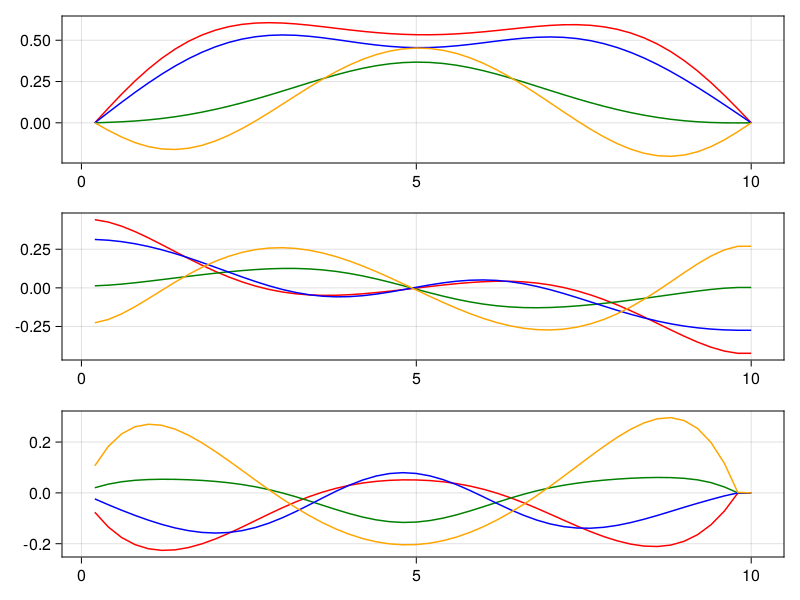

In [27]:
plot_control(rob_prob_5)

In [35]:
save("saved-pulses/single_qubit_gateset_R1e-2.jld2", rob_prob_5.trajectory)

# From 1.0 bound gate, no constraint, max regularization

In [28]:
trajectory = copy(rob_prob_1.trajectory)
parameters = deepcopy(prob.params)

objective = DefaultObjective()
objective += QuadraticRegularizer(:dda, trajectory, 1e-1)
objective += QuadraticRegularizer(:a, trajectory, 1e-1)

update_bound!(trajectory, :a, Inf)
update_bound!(trajectory, :dda, Inf)
constraints = trajectory_constraints(trajectory)

ipopt_options = Options()
ipopt_options.hessian_approximation = "limited-memory"

rob_prob_6 = UnitaryRobustnessProblem(
    H_crosstalk,
    trajectory,
    prob.system,
    objective,
    prob.integrators,
    constraints;
    final_fidelity=0.9999,
    verbose=false,
    build_trajectory_constraints=false,
    hessian_approximation=true,
    ipopt_options=ipopt_options
)

            memory estimate for stored jacobians: T * sizeof(∂f) = 50 * 0.000442944 = 0.022147200000000002 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(525) … MOI.VariableIndex(25153) MOI.VariableIndex(25677); MOI.VariableIndex(2) MOI.VariableIndex(526) … MOI.VariableIndex(25154) MOI.VariableIndex(25678); … ; MOI.VariableIndex(523) MOI.VariableIndex(1047) … MOI.VariableIndex(25675) MOI.VariableIndex(26199); MOI.VariableIndex(524) MOI.VariableIndex(1048) … MOI.VariableIndex(25676) MOI.VariableIndex(26200)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 16, 16), sparse(Int64[], Int64[], Float64[], 16, 16), SparseArrays.SparseMatrixCSC{Float64, Int64}[sparse([9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16, 16), sparse([5, 6, 7, 8, 1, 2, 3, 4, 13, 14, 15, 16, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [29]:
solve!(rob_prob_6; max_iter=200)

println("Fidelity: ", unitary_fidelity(rob_prob_6))
println("Robustness: ", infidelity_robustness(H_crosstalk, rob_prob_6))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:   894096
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    25680
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25480
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.2352062e-02 2.16e-04 1.36e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  8.2309279e-02 1.34e-03 2.45e-02  -4.0 1.16e-02    -  1.00e+00 8.55e-01h  1


   2  7.4203704e-02 8.46e-03 7.83e-02  -4.0 1.13e+00    -  1.00e+00 1.00e+00h  1


   3  6.5522098e-02 1.04e-03 2.48e-02  -4.0 4.18e-01    -  1.00e+00 1.00e+00h  1


   4  6.3149874e-02 4.42e-04 1.23e-03  -4.0 9.75e-02    -  1.00e+00 1.00e+00h  1


   5  6.1607089e-02 3.11e-03 3.96e-01  -4.0 7.85e-01    -  1.00e+00 4.28e-01H  1


   6  6.0192145e-02 1.72e-03 1.46e-02  -4.0 4.61e-01    -  1.00e+00 1.00e+00h  1


   7  5.8750572e-02 3.60e-04 7.49e-03  -4.0 3.73e-01    -  1.00e+00 1.00e+00h  1


   8  5.8077315e-02 2.54e-04 1.42e-03  -4.0 1.37e-01    -  1.00e+00 1.00e+00h  1


   9  5.8323209e-02 5.48e-05 1.81e-03  -4.0 3.42e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.8535352e-02 1.76e-05 3.16e-03  -4.0 4.51e-02    -  1.00e+00 1.00e+00H  1


  11  5.8547790e-02 1.54e-05 1.08e-01  -4.0 8.35e-02    -  1.00e+00 2.50e-01h  3


  12  5.8535103e-02 2.80e-05 1.83e-01  -4.3 1.22e-01    -  1.00e+00 2.50e-01h  3


  13  5.8512519e-02 3.71e-05 6.27e-02  -4.3 1.40e-01    -  1.00e+00 2.50e-01h  3


  14  5.8469994e-02 1.13e-04 7.05e-03  -4.0 6.58e-02    -  1.00e+00 1.00e+00h  1


  15  5.8770717e-02 7.35e-05 1.23e-01  -4.1 1.28e-01    -  1.00e+00 8.56e-01H  1


  16  5.8216235e-02 4.96e-05 5.16e-03  -4.1 1.99e-01    -  1.00e+00 1.00e+00f  1


  17  5.8057764e-02 4.35e-05 3.57e-03  -4.0 5.01e-02    -  1.00e+00 1.00e+00h  1


  18  5.8167809e-02 9.78e-06 2.69e-03  -4.0 8.81e-02    -  1.00e+00 1.00e+00H  1


  19  5.8078738e-02 5.53e-05 3.98e-01  -4.0 8.25e-02    -  1.00e+00 5.00e-01h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.8016372e-02 2.79e-04 1.32e-01  -4.1 1.02e-01    -  1.00e+00 5.00e-01h  2


  21  5.7953365e-02 3.64e-04 3.95e-01  -4.0 8.41e-01    -  1.00e+00 1.25e-01h  4


  22  5.7914691e-02 3.03e-04 2.51e-01  -4.0 4.37e-01    -  1.00e+00 2.50e-01h  3


  23  5.7998943e-02 1.48e-04 7.87e-03  -4.0 1.76e-01    -  1.00e+00 1.00e+00h  1


  24  5.7694292e-02 1.81e-04 1.12e-03  -4.0 1.86e-01    -  1.00e+00 1.00e+00h  1


  25  5.7986335e-02 3.04e-05 3.24e-03  -4.0 1.16e-01    -  1.00e+00 1.00e+00h  1


  26  5.7781614e-02 2.96e-05 6.90e-04  -4.0 1.04e-01    -  1.00e+00 1.00e+00h  1


  27  5.7889354e-02 9.49e-06 1.60e-03  -4.0 4.39e-02    -  1.00e+00 1.00e+00h  1


  28  5.7898348e-02 4.52e-06 9.57e-04  -4.0 4.41e-02    -  1.00e+00 1.00e+00h  1


  29  5.7903440e-02 1.38e-06 8.72e-04  -4.0 1.17e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.7911559e-02 4.69e-07 3.55e-04  -4.0 8.97e-03    -  1.00e+00 1.00e+00h  1


  31  5.7913105e-02 7.59e-08 1.26e-04  -4.0 2.67e-03    -  1.00e+00 1.00e+00h  1


  32  5.7913652e-02 1.50e-08 1.06e-04  -4.0 1.15e-03    -  1.00e+00 1.00e+00h  1


  33  5.7924033e-02 2.21e-09 1.21e-03  -4.0 9.06e-03    -  1.00e+00 1.00e+00H  1


  34  5.7924102e-02 2.37e-09 1.97e-02  -4.0 3.81e-02    -  1.00e+00 3.91e-03h  9


  35  5.7917603e-02 1.28e-09 8.95e-04  -4.1 1.74e-02    -  1.00e+00 1.00e+00H  1


  36  5.7942333e-02 4.26e-07 6.03e-04  -4.0 2.49e-02    -  1.00e+00 1.00e+00h  1


  37  5.7913189e-02 4.02e-07 2.33e-04  -4.1 5.34e-03    -  1.00e+00 1.00e+00h  1


  38  5.7869526e-02 8.03e-07 5.89e-04  -6.2 4.62e-03    -  1.00e+00 1.00e+00h  1


  39  5.7946765e-02 1.52e-06 5.00e-04  -4.0 1.53e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7933702e-02 9.46e-08 1.98e-04  -4.0 7.26e-03    -  1.00e+00 1.00e+00h  1


  41  5.7873860e-02 1.15e-06 7.95e-04  -6.0 4.55e-03    -  1.00e+00 1.00e+00h  1


  42  5.7859588e-02 2.03e-07 1.84e-04  -6.0 6.55e-03    -  1.00e+00 1.00e+00h  1


  43  5.7955588e-02 1.77e-06 4.71e-04  -4.0 5.56e-03    -  1.00e+00 1.00e+00h  1


  44  5.7938944e-02 6.20e-08 1.23e-04  -3.9 1.23e-03    -  1.00e+00 1.00e+00h  1


  45  5.7883407e-02 7.37e-07 5.79e-04  -5.9 1.93e-03    -  1.00e+00 1.00e+00h  1


  46  5.7856992e-02 2.95e-07 1.18e-03  -5.9 2.12e-03    -  1.00e+00 9.81e-01h  1


  47  5.7954934e-02 1.90e-06 6.49e-04  -4.0 2.88e-03    -  1.00e+00 1.00e+00f  1


  48  5.7936354e-02 6.26e-08 5.99e-05  -3.9 5.66e-04    -  1.00e+00 1.00e+00h  1


  49  5.7880945e-02 5.93e-07 4.58e-04  -5.9 1.77e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.7854976e-02 1.94e-07 2.08e-03  -5.9 2.26e-03    -  1.00e+00 9.71e-01h  1


  51  5.7954337e-02 1.75e-06 5.30e-04  -4.0 2.89e-03    -  1.00e+00 1.00e+00f  1


  52  5.7935524e-02 8.41e-08 1.66e-04  -3.9 9.28e-04    -  1.00e+00 1.00e+00h  1


  53  5.7877997e-02 6.66e-07 4.30e-04  -5.9 1.75e-03    -  1.00e+00 1.00e+00h  1


  54  5.7856080e-02 1.38e-07 1.64e-04  -5.9 1.30e-03    -  1.00e+00 9.97e-01h  1


  55  5.7955588e-02 1.86e-06 5.51e-04  -4.0 2.84e-03    -  1.00e+00 1.00e+00f  1


  56  5.7935662e-02 1.89e-07 2.94e-04  -3.9 1.54e-03    -  1.00e+00 1.00e+00h  1


  57  5.7879020e-02 6.67e-07 5.87e-04  -5.9 1.74e-03    -  1.00e+00 1.00e+00h  1


  58  5.7856684e-02 1.04e-07 2.63e-05  -5.9 7.14e-04    -  1.00e+00 1.00e+00h  1


  59  5.7955080e-02 1.89e-06 5.59e-04  -4.0 2.80e-03    -  1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.7937286e-02 6.39e-08 1.11e-04  -3.9 6.43e-04    -  1.00e+00 1.00e+00h  1


  61  5.7879356e-02 6.89e-07 6.05e-04  -5.9 1.73e-03    -  1.00e+00 1.00e+00h  1


  62  5.7854375e-02 3.05e-07 2.36e-03  -5.9 3.33e-03    -  1.00e+00 9.69e-01h  1


  63  5.7952648e-02 1.81e-06 5.46e-04  -4.0 2.86e-03    -  1.00e+00 1.00e+00f  1


  64  5.7934239e-02 6.24e-08 7.49e-05  -3.9 5.53e-04    -  1.00e+00 1.00e+00h  1


  65  5.7879987e-02 5.91e-07 4.00e-04  -5.9 1.74e-03    -  1.00e+00 1.00e+00h  1


  66  5.7851133e-02 6.74e-07 4.72e-03  -5.9 4.20e-03    -  1.00e+00 9.50e-01h  1


  67  5.7950692e-02 2.02e-06 5.51e-04  -4.0 3.32e-03    -  1.00e+00 1.00e+00f  1


  68  5.7933369e-02 6.00e-08 6.60e-05  -3.9 6.45e-04    -  1.00e+00 1.00e+00h  1


  69  5.7878347e-02 5.70e-07 3.29e-04  -5.9 2.10e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.7853872e-02 1.61e-07 1.30e-03  -5.9 1.31e-03    -  1.00e+00 9.80e-01h  1


  71  5.7955474e-02 1.93e-06 7.86e-04  -4.0 4.20e-03    -  1.00e+00 1.00e+00f  1


  72  5.7937403e-02 9.55e-07 8.94e-04  -3.9 4.83e-03    -  1.00e+00 1.00e+00h  1


  73  5.7874604e-02 7.34e-07 4.72e-04  -5.9 2.56e-03    -  1.00e+00 1.00e+00h  1


  74  5.7854480e-02 9.43e-08 2.96e-05  -5.9 1.26e-03    -  1.00e+00 1.00e+00h  1


  75  5.7955688e-02 1.95e-06 6.72e-04  -4.0 4.04e-03    -  1.00e+00 1.00e+00f  1


  76  5.7937125e-02 4.14e-07 5.84e-04  -3.9 3.24e-03    -  1.00e+00 1.00e+00h  1


  77  5.7872170e-02 8.51e-07 5.72e-04  -5.9 3.26e-03    -  1.00e+00 1.00e+00h  1


  78  5.7853701e-02 2.51e-07 1.12e-04  -5.9 2.58e-03    -  1.00e+00 1.00e+00h  1


  79  5.7952733e-02 2.07e-06 6.14e-04  -4.0 4.19e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.7934007e-02 8.98e-08 9.72e-05  -3.9 1.63e-03    -  1.00e+00 1.00e+00h  1


  81  5.7877859e-02 8.25e-07 5.20e-04  -5.9 2.88e-03    -  1.00e+00 1.00e+00h  1


  82  5.7849613e-02 2.69e-07 3.61e-03  -5.9 2.10e-03    -  1.00e+00 9.57e-01h  1


  83  5.7953265e-02 2.82e-06 1.13e-03  -4.0 6.79e-03    -  1.00e+00 1.00e+00f  1


  84  5.7931677e-02 3.47e-06 8.91e-04  -4.0 9.40e-03    -  1.00e+00 1.00e+00h  1


  85  5.7862356e-02 1.43e-06 2.77e-04  -5.9 4.63e-03    -  1.00e+00 1.00e+00h  1


  86  5.7852885e-02 8.45e-08 8.61e-05  -5.9 3.07e-03    -  1.00e+00 1.00e+00h  1


  87  5.7955534e-02 2.87e-06 8.06e-04  -4.0 6.61e-03    -  1.00e+00 1.00e+00f  1


  88  5.7940110e-02 3.48e-06 1.44e-03  -3.9 7.61e-03    -  1.00e+00 1.00e+00h  1


  89  5.7921944e-02 2.02e-06 2.43e-04  -3.9 5.87e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.7876041e-02 5.75e-07 3.16e-04  -5.9 3.00e-03    -  1.00e+00 1.00e+00h  1


  91  5.7851440e-02 4.82e-07 2.51e-04  -5.9 5.86e-03    -  1.00e+00 1.00e+00h  1


  92  5.7854395e-02 3.42e-07 3.02e-04  -5.9 4.55e-03    -  1.00e+00 1.00e+00h  1


  93  5.7853425e-02 1.35e-07 1.02e-04  -5.9 2.32e-03    -  1.00e+00 1.00e+00h  1


  94  5.7954288e-02 5.04e-06 9.32e-04  -4.0 8.65e-03    -  1.00e+00 1.00e+00h  1


  95  5.7950916e-02 1.70e-06 1.36e-03  -3.9 2.02e-02    -  1.00e+00 1.00e+00h  1


  96  5.7924584e-02 2.06e-06 7.41e-04  -3.9 8.49e-03    -  1.00e+00 1.00e+00h  1


  97  5.7877477e-02 6.24e-07 7.05e-04  -5.9 3.08e-03    -  1.00e+00 1.00e+00h  1


  98  5.7852771e-02 1.24e-06 8.60e-04  -5.9 1.63e-02    -  1.00e+00 9.86e-01h  1


  99  5.7849258e-02 6.51e-07 3.07e-05  -5.9 9.92e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7950869e-02 2.47e-06 8.20e-04  -4.0 6.04e-03    -  1.00e+00 1.00e+00h  1


 101  5.7932808e-02 1.09e-07 2.07e-04  -3.9 2.64e-03    -  1.00e+00 1.00e+00h  1


 102  5.7860284e-02 2.58e-06 1.25e-03  -5.9 7.97e-03    -  1.00e+00 1.00e+00h  1


 103  5.7838763e-02 2.93e-06 9.25e-04  -5.9 8.07e-03    -  1.00e+00 1.00e+00h  1


 104  5.7927513e-02 5.38e-06 8.26e-04  -4.0 7.81e-03    -  1.00e+00 1.00e+00h  1


 105  5.7928066e-02 2.30e-07 1.08e-04  -4.0 2.45e-03    -  1.00e+00 1.00e+00h  1


 106  5.7871713e-02 1.18e-06 4.32e-04  -5.9 4.12e-03    -  1.00e+00 1.00e+00h  1


 107  5.7851531e-02 4.03e-07 2.67e-04  -5.9 4.46e-03    -  1.00e+00 9.99e-01h  1


 108  5.7853817e-02 1.45e-07 3.03e-04  -5.9 2.64e-03    -  1.00e+00 1.00e+00h  1


 109  5.7854495e-02 2.46e-08 4.40e-05  -5.9 9.98e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.7954004e-02 5.37e-06 1.47e-03  -4.0 1.09e-02    -  1.00e+00 1.00e+00f  1


 111  5.7941355e-02 4.63e-06 1.21e-03  -4.0 2.50e-02    -  1.00e+00 1.00e+00h  1


 112  5.7897064e-02 4.74e-06 8.26e-04  -4.0 7.67e-03    -  1.00e+00 1.00e+00h  1


 113  5.7875630e-02 1.49e-07 4.82e-04  -5.9 1.81e-03    -  1.00e+00 1.00e+00h  1


 114  5.7855576e-02 3.39e-07 4.16e-04  -5.9 1.38e-02    -  1.00e+00 1.00e+00h  1


 115  5.7855624e-02 2.14e-07 1.79e-04  -5.9 6.21e-03    -  1.00e+00 1.00e+00h  1


 116  5.7854563e-02 2.03e-07 2.75e-04  -5.9 6.93e-03    -  1.00e+00 1.00e+00h  1


 117  5.7855404e-02 9.15e-08 3.47e-05  -5.9 6.12e-03    -  1.00e+00 1.00e+00h  1


 118  5.7856265e-02 7.83e-08 2.19e-04  -5.9 1.94e-03    -  1.00e+00 1.00e+00h  1


 119  5.7855159e-02 5.58e-08 3.92e-06  -5.9 1.65e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  5.7854705e-02 6.11e-11 2.35e-07  -8.9 2.85e-05    -  1.00e+00 1.00e+00h  1


 121  5.7945076e-02 2.30e-06 8.81e-04  -4.0 4.59e-03    -  1.00e+00 1.00e+00f  1


 122  5.7925579e-02 3.57e-07 3.58e-04  -3.9 2.11e-03    -  1.00e+00 1.00e+00h  1


 123  5.7874849e-02 7.28e-07 7.14e-04  -5.9 2.40e-03    -  1.00e+00 1.00e+00h  1


 124  5.7854116e-02 1.21e-07 2.32e-05  -5.9 7.35e-04    -  1.00e+00 1.00e+00h  1


 125  5.7856417e-02 2.49e-09 9.92e-06  -5.9 3.23e-04    -  1.00e+00 1.00e+00h  1


 126  5.7855316e-02 3.30e-10 6.32e-07  -8.8 1.08e-04    -  1.00e+00 1.00e+00h  1


 127  5.7855382e-02 4.75e-13 5.82e-07  -8.8 1.81e-04    -  1.00e+00 1.00e+00H  1


 128  5.7939662e-02 2.99e-06 1.34e-03  -4.0 7.52e-03    -  1.00e+00 1.00e+00f  1


 129  5.7917769e-02 2.30e-06 5.68e-04  -4.0 9.07e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.7867541e-02 8.14e-07 3.71e-04  -5.9 3.34e-03    -  1.00e+00 1.00e+00h  1


 131  5.7856162e-02 1.27e-07 1.65e-04  -5.9 4.12e-03    -  1.00e+00 1.00e+00h  1


 132  5.7857120e-02 1.47e-08 1.96e-05  -5.9 1.82e-03    -  1.00e+00 1.00e+00h  1


 133  5.7857304e-02 1.91e-09 1.91e-05  -5.9 3.34e-04    -  1.00e+00 1.00e+00h  1


 134  5.7857247e-02 5.17e-10 3.39e-07  -5.9 1.00e-04    -  1.00e+00 1.00e+00h  1


 135  5.7856240e-02 2.45e-10 3.95e-07  -8.9 3.54e-05    -  1.00e+00 1.00e+00h  1


 136  5.7856217e-02 1.70e-11 7.07e-08  -8.9 8.09e-05    -  1.00e+00 1.00e+00h  1


 137  5.7856023e-02 1.78e-09 2.28e-05  -8.9 4.44e-04    -  1.00e+00 1.00e+00h  1


 138  5.7855660e-02 2.33e-08 1.13e-04  -8.9 1.05e-03    -  1.00e+00 1.00e+00h  1


 139  5.7855559e-02 1.59e-08 1.29e-04  -8.9 7.56e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  5.7856202e-02 2.23e-10 1.90e-06  -8.9 8.45e-04    -  1.00e+00 1.00e+00H  1


 141  5.7855868e-02 3.39e-09 2.72e-05  -8.9 1.03e-03    -  1.00e+00 1.00e+00h  1


 142  5.7855828e-02 2.43e-09 1.24e-05  -8.9 2.31e-04    -  1.00e+00 1.00e+00h  1


 143  5.7856017e-02 8.91e-10 5.29e-06  -8.9 4.95e-04    -  1.00e+00 1.00e+00h  1


 144  5.7855969e-02 2.98e-10 8.19e-08  -8.9 6.63e-05    -  1.00e+00 1.00e+00h  1


 145  5.7856407e-02 2.05e-13 5.82e-06  -8.9 7.24e-04    -  1.00e+00 1.00e+00H  1


 146  5.7855746e-02 1.64e-08 5.54e-05  -8.9 7.40e-04    -  1.00e+00 1.00e+00h  1


 147  5.7855800e-02 1.23e-08 3.62e-05  -8.9 2.18e-04    -  1.00e+00 2.50e-01h  3


 148  5.7855733e-02 4.27e-10 1.11e-05  -8.9 9.61e-04    -  1.00e+00 1.00e+00H  1


 149  5.7855889e-02 4.27e-10 6.28e-07  -8.9 8.65e-04    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  5.7855951e-02 2.96e-13 9.65e-07  -8.9 4.07e-04    -  1.00e+00 1.00e+00H  1


 151  5.7855923e-02 4.24e-13 8.90e-07  -8.9 3.09e-04    -  1.00e+00 1.00e+00H  1


 152  5.7855848e-02 1.03e-13 6.02e-06  -8.9 1.80e-03    -  1.00e+00 1.00e+00H  1


 153  5.7855904e-02 2.65e-14 6.81e-08  -8.9 1.57e-03    -  1.00e+00 1.00e+00H  1


 154  5.7855914e-02 1.71e-14 2.12e-07  -8.9 3.96e-05    -  1.00e+00 1.00e+00H  1


 155  5.7855903e-02 7.54e-15 4.68e-08  -8.9 2.25e-05    -  1.00e+00 1.00e+00H  1


 156  5.7855903e-02 7.77e-16 1.98e-08  -8.9 8.56e-06    -  1.00e+00 1.00e+00H  1


 157  5.7855896e-02 7.77e-16 4.04e-08  -8.9 9.09e-06    -  1.00e+00 1.00e+00H  1


 158  5.7855802e-02 4.15e-13 9.76e-07  -8.9 1.14e-04    -  1.00e+00 1.00e+00H  1


 159  5.7855859e-02 1.97e-15 5.05e-07  -8.9 2.13e-04    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.7855889e-02 5.55e-16 2.28e-07  -8.9 1.43e-04    -  1.00e+00 1.00e+00H  1


 161  5.7855847e-02 2.96e-14 3.27e-07  -8.9 9.12e-05    -  1.00e+00 1.00e+00H  1


 162  5.7855855e-02 1.78e-15 2.68e-07  -8.9 1.66e-04    -  1.00e+00 1.00e+00H  1


 163  5.7855865e-02 4.44e-16 6.42e-08  -8.9 8.63e-05    -  1.00e+00 1.00e+00H  1


 164  5.7855888e-02 4.44e-16 2.34e-07  -8.9 7.12e-05    -  1.00e+00 1.00e+00H  1


 165  5.7855861e-02 4.44e-16 1.70e-07  -8.9 6.86e-05    -  1.00e+00 1.00e+00H  1


 166  5.7855863e-02 4.44e-16 6.75e-07  -8.9 1.64e-04    -  1.00e+00 1.00e+00H  1


 167  5.7855861e-02 8.40e-16 3.03e-07  -8.9 1.40e-04    -  1.00e+00 1.00e+00H  1


 168  5.7855880e-02 3.33e-16 6.63e-07  -8.9 1.97e-04    -  1.00e+00 1.00e+00H  1


 169  5.7855870e-02 4.44e-16 4.19e-07  -8.9 8.27e-05    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.7855866e-02 4.44e-16 5.07e-07  -8.9 2.30e-04    -  1.00e+00 1.00e+00H  1


 171  5.7855856e-02 6.66e-16 4.57e-07  -8.9 6.31e-05    -  1.00e+00 1.00e+00H  1


 172  5.7855880e-02 3.33e-16 2.56e-07  -8.9 1.86e-04    -  1.00e+00 1.00e+00H  1


 173  5.7855861e-02 4.44e-16 1.45e-07  -8.9 7.42e-05    -  1.00e+00 1.00e+00H  1


 174  5.7855867e-02 3.33e-16 1.96e-07  -8.9 6.39e-05    -  1.00e+00 1.00e+00H  1


 175  5.7855865e-02 4.44e-16 3.22e-08  -8.9 4.67e-05    -  1.00e+00 1.00e+00H  1


 176  5.7855866e-02 4.44e-16 1.12e-07  -8.9 3.14e-05    -  1.00e+00 1.00e+00H  1


 177  5.7855865e-02 4.44e-16 6.67e-09  -8.9 2.77e-05    -  1.00e+00 1.00e+00H  1


 178  5.7855865e-02 4.44e-16 8.31e-09  -9.0 3.98e-06    -  1.00e+00 1.00e+00H  1


 179  5.7855865e-02 1.47e-14 1.98e-09  -9.0 1.91e-06    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  5.7855865e-02 7.77e-16 5.28e-09  -9.0 1.35e-06    -  1.00e+00 1.00e+00H  1


 181  5.7855865e-02 4.66e-14 5.66e-09  -9.0 1.03e-06    -  1.00e+00 1.00e+00h  1


 182  5.7855863e-02 1.15e-11 1.68e-07  -9.0 2.56e-05    -  1.00e+00 1.00e+00h  1


 183  5.7855860e-02 5.22e-12 1.01e-07  -9.0 1.75e-05    -  1.00e+00 1.00e+00h  1


 184  5.7855864e-02 6.83e-13 4.22e-08  -9.0 2.82e-05    -  1.00e+00 1.00e+00h  1


 185  5.7855863e-02 3.94e-13 3.07e-08  -9.0 9.20e-06    -  1.00e+00 1.00e+00h  1


 186  5.7855860e-02 2.68e-12 4.42e-08  -9.0 1.74e-05    -  1.00e+00 1.00e+00h  1


 187  5.7855855e-02 8.52e-11 1.21e-07  -9.0 3.25e-05    -  1.00e+00 1.00e+00h  1


 188  5.7855858e-02 6.59e-11 5.49e-08  -9.0 8.76e-05    -  1.00e+00 2.50e-01h  3


 189  5.7855845e-02 2.32e-10 7.89e-07  -9.0 2.49e-04    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  5.7855853e-02 1.75e-10 5.44e-07  -9.0 2.70e-04    -  1.00e+00 2.50e-01h  3


 191  5.7855854e-02 1.53e-10 4.75e-07  -9.0 1.81e-04    -  1.00e+00 1.25e-01h  4


 192  5.7855855e-02 1.51e-10 4.65e-07  -9.0 1.75e-04    -  1.00e+00 1.56e-02h  7


 193  5.7855860e-02 6.80e-11 3.65e-07  -9.0 1.76e-04    -  1.00e+00 1.00e+00h  1


 194  5.7855860e-02 6.70e-11 3.57e-07  -9.0 5.17e-05    -  1.00e+00 1.56e-02h  7


 195  5.7855860e-02 6.69e-11 3.58e-07  -9.0 5.15e-05    -  1.00e+00 1.95e-03h 10


 196  5.7855860e-02 6.68e-11 3.58e-07  -9.0 5.09e-05    -  1.00e+00 4.88e-04h 12


 197  5.7855860e-02 6.68e-11 3.57e-07  -9.0 5.07e-05    -  1.00e+00 2.44e-04h 13


 198  5.7855860e-02 6.68e-11 3.57e-07  -9.0 5.05e-05    -  1.00e+00 1.53e-05h 17


 199  5.7855866e-02 2.51e-11 3.17e-09  -9.0 5.04e-05    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.7855866e-02 6.66e-16 2.14e-09  -9.0 2.77e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 200

                                   (scaled)                 (unscaled)
Objective...............:   5.7855866223348748e-02    5.7855866223348748e-02
Dual infeasibility......:   2.1409852797430774e-09    2.1409852797430774e-09
Constraint violation....:   6.6613381477509392e-16    6.6613381477509392e-16
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909035706e-10    9.0909090909035706e-10
Overall NLP error.......:   9.9999090909090913e-05    9.9999090909090913e-05


Number of objective function evaluations             = 386
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 386
Number of inequality constraint evaluations          = 386
Number of equality constraint Jacob

In [48]:
println("max(a): ", maximum(rob_prob_6.trajectory[:a]))
println("max(dda): ", maximum(rob_prob_6.trajectory[:dda]))

max(a): 0.5953708812389078
max(dda): 0.024790066871688752


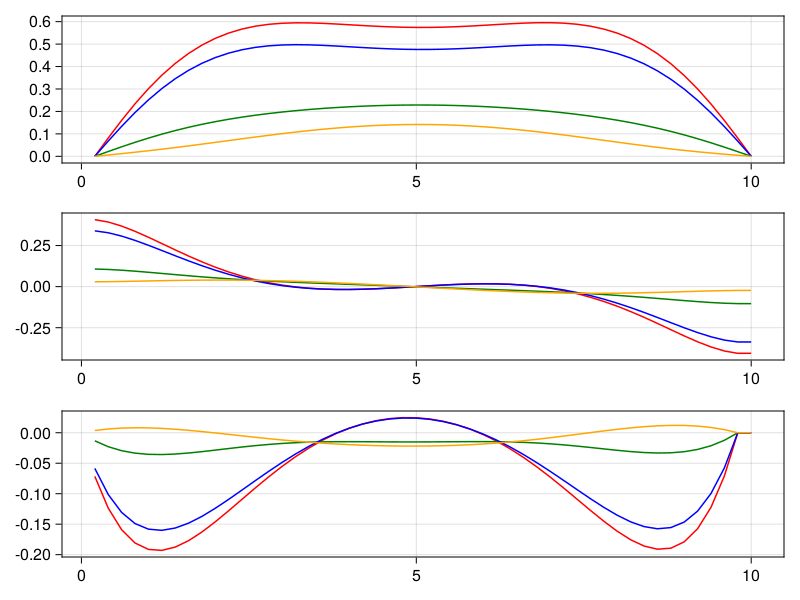

In [30]:
plot_control(rob_prob_6)

In [36]:
save("saved-pulses/single_qubit_gateset_R1e-1.jld2", rob_prob_6.trajectory)